## Getting started

In [36]:
import re
import sys
from pathlib import Path
import time
from datetime import datetime as dt
from parselmouth import Sound
from parselmouth.praat import call as pcall
import scipy.io.wavfile
import scipy.signal
import librosa
import numpy as np
import pandas as pd
import multiprocess as mp

from audiolabel import read_label, df2tg
from phonlab.tidypraat import formant2df
from phonlab.utils import dir2df

import matplotlib.pyplot as plt

In [38]:
wavfile = Path('../cetiprojects/focalclicks.left.2023-11-29T162357.pknorm.1800samples.wav')
m = re.search(r'(?P<samples>\d+)samples', str(wavfile))
nsamp = int(m.group('samples'))      # Number of samples per click as encoded in the filename
tgfile = Path('../cetiprojects/focalclicks.2023-11-29T162357.1800samples.TextGrid')
annofile = Path('JUN181153focalclicks_2023-11-29T162357_1800samples_25mscodas.TextGrid')
vowelfile = Path('./pinchycodas.csv')  # Pinchy vowels from paper's Table 2
resdir = Path('./lpc')
chunkdir = resdir / 'cpuchunks'
#outdir = Path('./formants')
#outdir.mkdir(parents=True, exist_ok=True)

## Load focal coda annotations and audio

Load the labelled annotations from the textgrid and merge with hand-labelled vowel symbols.

In [70]:
def load_anno(annofile):
    '''
    Load annotations of codanum, vowel category, and whale from a textgrid.
    '''
    tiers = read_label(annofile, ftype='praat')
    vt = tiers[1][tiers[1]['label'] != ''].rename({'label': 'handv'}, axis='columns')
    vt = vt.merge(tiers[2][['t1', 'label']], on='t1').rename({'label': 'codanum'}, axis='columns')
    wdf = tiers[0].rename({'label': 'whale'}, axis='columns')  # TODO: check for empty whale values
    wdf['whale'] = wdf['whale'].fillna('')
    vt = pd.merge_asof(vt, wdf[['t1', 'whale']], on='t1')
#    vt[['whale', 'handv']] = vt[['whale', 'handv']].astype('category')
    return vt[['codanum', 'handv', 'whale']]

In [79]:
[whaledf, codadf, clickdf] = read_label(tgfile, ftype='praat')
codadf['t1_coda'] = codadf['t1']
cocl = pd.merge_asof(
    clickdf.drop('fname', axis='columns'),
    codadf.drop('fname', axis='columns'),
    on='t1',
    suffixes=['_click', '_coda']
).rename(
    {'label_click': 'clicknum', 'label_coda': 'codanum'}, axis='columns'
).sort_values('t1')
cocl['audidx'] = np.arange(len(cocl))
# Hand-labelling vowels from the .pdf
vt = load_anno(annofile)
cocl = cocl.merge(vt, how='left', on='codanum').fillna('')
cocl

,t1,t2_click,clicknum,t2_coda,codanum,t1_coda,audidx,handv,whale
0,0.000,0.015,1,0.075,4933,0.00,0,i,ATWOOD
1,0.015,0.030,2,0.075,4933,0.00,1,i,ATWOOD
2,0.030,0.045,3,0.075,4933,0.00,2,i,ATWOOD
3,0.045,0.060,4,0.075,4933,0.00,3,i,ATWOOD
4,0.060,0.075,5,0.075,4933,0.00,4,i,ATWOOD
...,...,...,...,...,...,...,...,...,...
7176,107.640,107.655,1,107.715,8159,107.64,7176,,
7177,107.655,107.670,2,107.715,8159,107.64,7177,,
7178,107.670,107.685,3,107.715,8159,107.64,7178,,
7179,107.685,107.700,4,107.715,8159,107.64,7179,,


Load the audio data and shape to dimensions `click` x `samples` (15ms).

audio dims: (7181, 1800); shape matches the 7181 rows of `cocl`


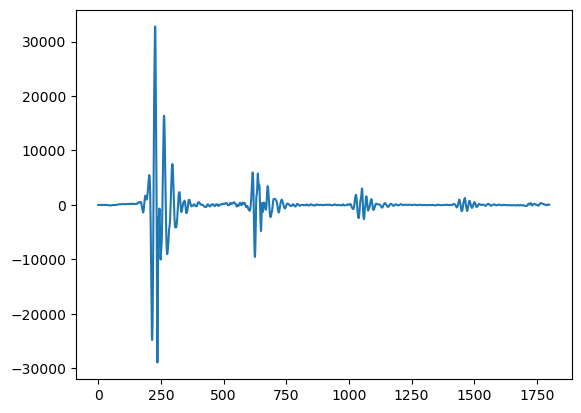

In [4]:
rate, audio = scipy.io.wavfile.read(wavfile)
audio = audio.reshape([len(cocl), nsamp])
assert(audio.shape[0] == len(cocl))
print(f'audio dims: {audio.shape}; shape matches the {len(cocl)} rows of `cocl`')
plt.plot(audio[4747]);   # Plot a single click

## Set up hyperparameters and analysis functions

The first set of params are for Praat's `To FormantPath...` function in the order required by parselmouth's `call`. Additonal paramerers select the analysis function and portions of the signal to undergo analysis. All param values are specified as lists, and the result is a permutation of all param elements as rows of a dataframe.

Parameter sets with a `timestep` greater than the analysis window `winlen` are excluded from the result. If `toffset` plus `sigdur` 

The `cpuchunk` value is not an analysis parameter. It is used as a grouping value for executing multiple processes in parallel.

### Shared values

In [5]:
# Floating point values will be rounded to specified number of decimals, which makes\n",
# it easier to select param values exactly.\n",
paramprecision = {
    'timestep': 5,
    'winlen': 5,
    'rlpcstd': 5,
    'toffset': 5,
    'sigdur': 5,
}

### Click analysis parameters

In [6]:
praatparams = {
    'timestep': np.array([0.0005, 0.00075, 0.001, 0.002, 0.003, 0.004], dtype=np.float32),
    'numformant': np.array([2], dtype=np.int32),
    'midformantceil': np.array([12000], dtype=np.int32),
    'winlen': np.array([0.00075, 0.001, 0.002, 0.003, 0.004], dtype=np.float32),
    'preemphhz': np.array([40000], dtype=np.int32),
    'lpcmodel': np.array(['Robust'], dtype='object'),
    'ceilstep': np.array([0.02], dtype=np.float32),
    'numsteps': np.array([25], dtype=np.int32),  # Number of ceiling steps
    'marpletol1': np.array([1e-6], dtype=np.float32),  # Irrelevant for 'Robust' analysis, but required by Praat
    'marpletol2': np.array([1e-6], dtype=np.float32),  # Irrelevant for 'Robust' analysis, but required by Praat
    'rlpcstd': np.array([1.0, 1.5, 2.0], dtype=np.float32),
    'rlpciter': np.array([5], dtype=np.int32),
    'rlpctol': np.array([1e-12], dtype=np.float32),
    'getsrcmultichan': np.array(['no'], dtype='object')
}
otherparams = {
    'toffset': np.array([0.0, 0.0005], dtype=np.float32),   # time offset from beginning of click audio
    'sigdur': np.array([0.003, 0.0035, 0.004, 0.0045, 0.005, 0.015], dtype=np.float32)  # duration of audio from toffset
}
variedparamlist = [k for k, v in (praatparams | otherparams).items() if len(v) > 1]
# TODO: incorporate coef into varied params automatically
variedparamlist.append('coef')
for vp in variedparamlist:
    try:
        assert(vp in paramprecision.keys())
    except AssertionError:
        sys.stderr.write(f'Number of decimals for varied param `{vp}` must be defined in `paramprecision`.\n')
allparams = praatparams | otherparams
idx = pd.MultiIndex.from_product(allparams.values(), names=(praatparams | otherparams).keys())
paramdf = pd.DataFrame(index=idx).reset_index()
# To FormantPath... requires signal duration be > two analysis window lengths
badcombo = (paramdf['timestep'] > paramdf['winlen']) | \
           (paramdf['sigdur'] <= paramdf['winlen'] * 2) | \
           (paramdf['toffset'] + paramdf['sigdur'] > 0.015) | \
           ((paramdf['toffset'] < 0) & (paramdf['sigdur'] != otherparams['sigdur'][0]))  # sigdur is ignored for toffset < 0
paramdf.loc[paramdf['toffset'] < 0, 'sigdur'] = np.nan
paramdf = paramdf[~badcombo].reset_index(drop=True)
paramdf['cpuchunk'] = (paramdf.index % mp.cpu_count()).astype(np.int32)
paramdf = paramdf.astype('category')
print(variedparamlist)
paramdf

['timestep', 'winlen', 'rlpcstd', 'toffset', 'sigdur', 'coef']


Number of decimals for varied param `coef` must be defined in `paramprecision`.


,timestep,numformant,midformantceil,winlen,preemphhz,lpcmodel,ceilstep,numsteps,marpletol1,marpletol2,rlpcstd,rlpciter,rlpctol,getsrcmultichan,toffset,sigdur,cpuchunk
0,0.0005,2,12000,0.00075,40000,Robust,0.02,25,0.000001,0.000001,1.0,5,1.000000e-12,no,0.0,0.0030,0
1,0.0005,2,12000,0.00075,40000,Robust,0.02,25,0.000001,0.000001,1.0,5,1.000000e-12,no,0.0,0.0035,1
2,0.0005,2,12000,0.00075,40000,Robust,0.02,25,0.000001,0.000001,1.0,5,1.000000e-12,no,0.0,0.0040,2
3,0.0005,2,12000,0.00075,40000,Robust,0.02,25,0.000001,0.000001,1.0,5,1.000000e-12,no,0.0,0.0045,3
4,0.0005,2,12000,0.00075,40000,Robust,0.02,25,0.000001,0.000001,1.0,5,1.000000e-12,no,0.0,0.0050,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,0.0030,2,12000,0.00400,40000,Robust,0.02,25,0.000001,0.000001,1.5,5,1.000000e-12,no,0.0,0.0150,5
254,0.0030,2,12000,0.00400,40000,Robust,0.02,25,0.000001,0.000001,2.0,5,1.000000e-12,no,0.0,0.0150,6
255,0.0040,2,12000,0.00400,40000,Robust,0.02,25,0.000001,0.000001,1.0,5,1.000000e-12,no,0.0,0.0150,7
256,0.0040,2,12000,0.00400,40000,Robust,0.02,25,0.000001,0.000001,1.5,5,1.000000e-12,no,0.0,0.0150,0


### Coda analysis parameters

In [7]:
codapraatparams = {
    'timestep': np.array([0.003, 0.0035, 0.004, 0.0045, 0.005, 0.010, 0.0125, 0.0145, 0.015], dtype=np.float32),
    'numformant': np.array([2], dtype=np.int32),
    'midformantceil': np.array([12000], dtype=np.int32),
    'winlen': np.array([0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0145, 0.015], dtype=np.float32),
    'preemphhz': np.array([40000], dtype=np.int32),
    'lpcmodel': np.array(['Robust'], dtype='object'),
    'ceilstep': np.array([0.02], dtype=np.float32),
    'numsteps': np.array([25], dtype=np.int32),  # Number of ceiling steps
    'marpletol1': np.array([1e-6], dtype=np.float32),  # Irrelevant for 'Robust' analysis, but required by Praat
    'marpletol2': np.array([1e-6], dtype=np.float32),  # Irrelevant for 'Robust' analysis, but required by Praat
    'rlpcstd': np.array([1.0, 1.5, 2.0], dtype=np.float32),
    'rlpciter': np.array([5], dtype=np.int32),
    'rlpctol': np.array([1e-12], dtype=np.float32),
    'getsrcmultichan': np.array(['no'], dtype='object')
}
codaotherparams = {
    'toffset': np.array([0.0, 0.0005], dtype=np.float32),   # time offset from beginning of click audio
    'sigdur': codapraatparams['winlen']  # duration of audio from toffset
}
codavariedparamlist = [k for k, v in (codapraatparams | codaotherparams).items() if len(v) > 1]
for vp in codavariedparamlist:
    try:
        assert(vp in paramprecision.keys())
    except AssertionError:
        sys.stderr.write(f'Number of decimals for varied param `{vp}` must be defined in `paramprecision`.\n')
codaallparams = codapraatparams | codaotherparams
idx = pd.MultiIndex.from_product(codaallparams.values(), names=(codapraatparams | codaotherparams).keys())
codaparamdf = pd.DataFrame(index=idx).reset_index()
# To FormantPath... requires signal duration be > two analysis window lengths
codabadcombo = (codaparamdf['timestep'] > codaparamdf['winlen']) | \
           (codaparamdf['toffset'] + codaparamdf['winlen'] > codaparamdf['sigdur']) | \
           ((codaparamdf['toffset'] < 0) & (codaparamdf['sigdur'] != codaotherparams['sigdur'][0]))  # sigdur is ignored for toffset < 0
codaparamdf.loc[codaparamdf['toffset'] < 0, 'sigdur'] = np.nan
codaparamdf = codaparamdf[~codabadcombo].reset_index(drop=True)
codaparamdf['cpuchunk'] = (codaparamdf.index % mp.cpu_count()).astype(np.int32)
codaparamdf = codaparamdf.astype('category')
codaparamdf[codavariedparamlist]

,timestep,winlen,rlpcstd,toffset,sigdur
0,0.0030,0.003,1.0,0.0,0.0030
1,0.0030,0.003,1.0,0.0,0.0035
2,0.0030,0.003,1.0,0.0,0.0040
3,0.0030,0.003,1.0,0.0,0.0045
4,0.0030,0.003,1.0,0.0,0.0050
...,...,...,...,...,...
430,0.0145,0.015,1.5,0.0,0.0150
431,0.0145,0.015,2.0,0.0,0.0150
432,0.0150,0.015,1.0,0.0,0.0150
433,0.0150,0.015,1.5,0.0,0.0150


### Analysis functions

In [8]:
# Non-varied parameters that are defined in the global environment and used in functions.
downtotableparams = {
    'left_edge': 0.0,
    'right_edge': 0.0,   # All times in formantpath
    'coeff_by_track': '1 1',
    'power': 1.25,
    'inc_frame_num': 'no',
    'inc_time': 'yes',
    'num_time_decimal': 6,
    'inc_intensity': 'yes',
    'num_intensity_decimal': 3,
    'inc_num_formants': 'yes',
    'num_freq_decimal': 1,
    'inc_bw': 'yes',
    'inc_optimal_ceil': 'yes',
    'inc_min_stress': 'yes',
}
downtotabledtype = {
    'time(s)': np.float32,
    'intensity': np.float32,
    'nformants': np.int16,
    'F1(Hz)': np.float32,
    'B1(Hz)': np.float32,
    'F2(Hz)': np.float32,
    'B2(Hz)': np.float32,
    'Ceiling(Hz)': np.float32,
    'Stress': np.float32,
}
# Cols created by 'Down to Table (optimal interval)...'
downtotablecols = list(downtotabledtype.keys())

# Params for the find_main_pulse function
findpulseparams = {
    'w': 10,
    'onpct': 0.1,
    'offpct': 0.01
}

def doclick(df, fpathparams, tparams, audio, rate):
    try:
        if tparams['toffset'] < 0:
            # TODO: set t1idx to 1ms offset from start 
            t1idx, t2idx, _amplitude_envelope = find_main_pulse(audio[df['audidx']], *findpulseparams.values())
        else:
            t1idx = np.floor(tparams['toffset'] * rate).astype(int)
            t2idx = np.floor((tparams['toffset'] + tparams['sigdur']) * rate).astype(int)
        snd = Sound(audio[df['audidx'],t1idx:t2idx+1], rate)
        fp = pcall(snd, 'To FormantPath...', *fpathparams)
        # 'Down to Table (optimal interval)...': A command that creates a Table with formant frequency
        # values for the chosen interval of the selected FormantPath. The values in the table are from
        # the segment that has the lowest stress value for the fit of its formant tracks.
        opttable = pcall(fp, 'Down to Table (optimal interval)...', *downtotableparams.values())
        optmatrix = pcall(opttable, 'Down to Matrix')
        fmtdf = pd.DataFrame({
            c: pd.Series(optmatrix.values[:,i], dtype=downtotabledtype[c]) for i, c in enumerate(downtotablecols)
        })
#        fmtdf['f2pct'] = ((fmtdf['nformants'] == 2).sum() / len(fmtdf)).astype(np.float32)
        fmtdf['t1idx'] = t1idx
        fmtdf['t2idx'] = t2idx
        # Not necessary to use 'Get optimal ceiling...' as the value is equivalent
        # to 'Ceiling(Hz)' returned by 'Down to Table (optimal interval)...'
#        fmtdf['getoptceil'] = pcall(fp, 'Get optimal ceiling...', 0.0, 0.0, '3 3 3', 1.25)
    except Exception as e:
#        raise e
        fmtdf = pd.DataFrame({c: pd.Series([], dtype=downtotabledtype[c]) for i, c in enumerate(downtotablecols)})
#        fmtdf['f2pct'] = None
        try:
            fmtdf['t1idx'] = t1idx
            fmtdf['t2idx'] = t2idx
        except:
            fmtdf['t1idx'] = np.nan
            fmtdf['t2idx'] = np.nan
    fmtdf = fmtdf.reset_index(names='frameidx')
    fmtdf.index = [df.name] * len(fmtdf)
    return fmtdf

def docoda(df, fpathparams, tparams, audio, rate):
    try:
        if tparams['toffset'] < 0:
            # TODO: set t1idx to 1ms offset from start 
            t1idx, t2idx, _amplitude_envelope = find_main_pulse(audio[df['audidx']], *findpulseparams.values())
        else:
            t1idx = np.floor(tparams['toffset'] * rate).astype(int)
            t2idx = np.floor((tparams['toffset'] + tparams['sigdur']) * rate).astype(int)
        clickidx = df['audidx'].sort_values().unique()
        snd = Sound(audio[clickidx,t1idx:t2idx+1].ravel(), rate)
#        print(clickidx, t1idx, t2idx, snd.values.shape)
        fp = pcall(snd, 'To FormantPath...', *fpathparams)
        # 'Down to Table (optimal interval)...': A command that creates a Table with formant frequency
        # values for the chosen interval of the selected FormantPath. The values in the table are from
        # the segment that has the lowest stress value for the fit of its formant tracks.
        opttable = pcall(fp, 'Down to Table (optimal interval)...', *downtotableparams.values())
        optmatrix = pcall(opttable, 'Down to Matrix')
        fmtdf = pd.DataFrame({
            c: pd.Series(optmatrix.values[:,i], dtype=downtotabledtype[c]) for i, c in enumerate(downtotablecols)
        })
#        fmtdf['f2pct'] = ((fmtdf['nformants'] == 2).sum() / len(fmtdf)).astype(np.float32)
        fmtdf['t1idx'] = t1idx
        fmtdf['t2idx'] = t2idx
        # Not necessary to use 'Get optimal ceiling...' as the value is equivalent
        # to 'Ceiling(Hz)' returned by 'Down to Table (optimal interval)...'
#        fmtdf['getoptceil'] = pcall(fp, 'Get optimal ceiling...', 0.0, 0.0, '3 3 3', 1.25)
    except Exception as e:
#        raise e
        fmtdf = pd.DataFrame({c: pd.Series([], dtype=downtotabledtype[c]) for i, c in enumerate(downtotablecols)})
#        fmtdf['f2pct'] = None
        try:
            fmtdf['t1idx'] = t1idx
            fmtdf['t2idx'] = t2idx
        except:
            fmtdf['t1idx'] = np.nan
            fmtdf['t2idx'] = np.nan
    fmtdf = fmtdf.reset_index(names='frameidx')
    fmtdf.index = [df.name] * len(fmtdf)
    return fmtdf

def dochunk(paramdf, dodf, audio, rate, cpunum, outfile, return_dict):
    '''
    Work on a chunk of analysis rows and assign result to global `return_dict`.
    '''
    start = dt.now()
    clicklist = []
    for row in paramdf.itertuples():
        fpathparams = {a: getattr(row, a) for a in praatparams.keys()}
        tparams = {a: getattr(row, a) for a in otherparams.keys()}
        res = pd.concat(
            dodf.apply(
                doclick,
                axis='columns',
                args=[[v for v in fpathparams.values()], tparams, audio, rate]
            ).to_list()
        )
        allfmt = dodf.join(res) #.drop('codanum', axis='columns')
        varied = {   # Round param values so that they are easier to match exactly for selecting rows
            k: np.round(v, decimals=paramprecision[k]) \
                for k, v in (fpathparams | tparams).items() if k in variedparamlist
        }
        allfmt = allfmt.assign(**varied)
        clicklist.append(allfmt)
    retdf = pd.concat(clicklist, axis='rows') \
              .rename({
                  'time(s)': 'sec',
                  'F1(Hz)': 'f1',
                  'B1(Hz)': 'b1',
                  'F2(Hz)': 'f2',
                  'B2(Hz)': 'b2',
                  'Ceiling(Hz)': 'ceil',
              }, axis='columns')
    print(f'Creating {outfile}')
    retdf.to_feather(outfile)
    return_dict[cpunum] = {
        'start': start,
        'stop': dt.now(),
#        'df': retdf,
#        'res': res,
#        'dodf': dodf,
#        'allfmt': allfmt,
#        'row': row
    }

def find_main_pulse(d, w, onpct, offpct):
    '''
    Find the start and end indexes of the main click pulse. The start index
    is the first sample in a rolling window of the amplitude envelope where
    the mean of the window is greater than a threshold percentage of the
    difference of the maximum and minimum of the signal magnitude.
    '''
    pkidx = d.argmax()
    analytic_signal = scipy.hilbert(d)
    amplitude_envelope = pd.Series(np.abs(analytic_signal))
    onthresh = ((amplitude_envelope.max() - amplitude_envelope.min()) * onpct) + amplitude_envelope.min()
    offthresh = ((amplitude_envelope.max() - amplitude_envelope.min()) * offpct) + amplitude_envelope.min()
    startidx = np.nonzero(amplitude_envelope[:pkidx] >= onthresh)[0][0] - w
    stopidx = np.nonzero(amplitude_envelope[pkidx:] < offthresh)[0][0] + pkidx - w
    return (startidx, stopidx, amplitude_envelope)

def main_pulse_plots(d, startclickidx, n, w, onpct, offpct):
    nclickcols = 4
    nclickrows = np.ceil(n / 4).astype(int)
    fig, axs = plt.subplots(nclickrows, nclickcols, figsize=[16,nclickrows*3]);
    for nidx in np.arange(n):
        row = np.floor(nidx / nclickcols).astype(int)
        col = nidx % nclickcols
        audidx = startclickidx+nidx
        try:
            startidx, stopidx, amplitude_envelope = find_main_pulse(d[audidx], w, onpct, offpct)
            axs[row, col].autoscale(enable=True, axis='x', tight=True)
            axs[row, col].plot(d[audidx,:1000]);
            axs[row, col].plot(amplitude_envelope[:1000], 'y');
            axs[row, col].text(500, d[audidx].max()*0.90, f'audidx={audidx}');
            axs[row, col].plot(startidx, amplitude_envelope[startidx], 'or')
            axs[row, col].plot(stopidx+w, amplitude_envelope[stopidx+w], 'or')
            axs[row, col].axvspan(startidx, stopidx+w, facecolor='#2ca02c', alpha=0.15)
        except Exception as e:
            sys.stderr.write(f'Could not plot audidx {audidx} at subplot [{row}, {col}]\n')
#            raise e
    fig.savefig(f'first_pulses.{startclickidx}.{audidx}.{w}.{onpct}.{offpct}.png')
    return (fig, axs)

def analyze_clicks_by_chunks(paramdf, df, prefix, audio, rate):
    manager = mp.Manager()
    return_dict = manager.dict()
    procs = {}
    for g in paramdf.groupby('cpuchunk', observed=True):
        coefstr = downtotableparams['coeff_by_track'].replace(' ', '')
        outname = chunkdir / f'{prefix}.lpc.{coefstr}coef.cpuchunk{g[0]}.ft'
        procs[g[0]] = mp.Process(
            target=dochunk,
            args=(g[1], df, audio, rate, g[0], outname, return_dict)
        )
        procs[g[0]].start()
    return return_dict

def analyze_codas_by_chunks(paramdf, df, prefix, audio, rate):
    manager = mp.Manager()
    return_dict = manager.dict()
    procs = {}
    for g in paramdf.groupby('cpuchunk', observed=True):
        coefstr = downtotableparams['coeff_by_track'].replace(' ', '')
        outname = chunkdir / f'{prefix}.lpc.{coefstr}coef.cpuchunk{g[0]}.ft'
        print(f'Asking for {outname}')
        procs[g[0]] = mp.Process(
            target=dochunkcoda,
            args=(g[1], df, audio, rate, g[0], outname, return_dict)
        )
        procs[g[0]].start()
    return return_dict

def dochunkcoda(paramdf, dodf, audio, rate, cpunum, outfile, return_dict):
    '''
    Work on a chunk of analysis rows and assign result to global `return_dict`.
    '''
    start = dt.now()
    clicklist = []
    for row in paramdf.itertuples():
        fpathparams = {a: getattr(row, a) for a in praatparams.keys()}
        tparams = {a: getattr(row, a) for a in otherparams.keys()}
        allfmt = dodf.groupby('codanum')[dodf.columns].apply(
                docoda,
                *([v for v in fpathparams.values()], tparams, audio, rate)
        ).droplevel('codanum')
        varied = {   # Round param values so that they are easier to match exactly for selecting rows
            k: np.round(v, decimals=paramprecision[k]) \
                for k, v in (fpathparams | tparams).items() if k in variedparamlist
        }
        allfmt = allfmt.assign(**varied)
        clicklist.append(allfmt)
    retdf = pd.concat(clicklist, axis='rows') \
              .rename({
                  'time(s)': 'sec',
                  'F1(Hz)': 'f1',
                  'B1(Hz)': 'b1',
                  'F2(Hz)': 'f2',
                  'B2(Hz)': 'b2',
                  'Ceiling(Hz)': 'ceil',
              }, axis='columns')
    print(f'Creating {outfile}')
    retdf.to_feather(outfile)
    return_dict[cpunum] = {
        'start': start,
        'stop': dt.now(),
        'df': retdf,
#        'res': res,
#        'dodf': dodf,
#        'allfmt': allfmt,
#        'row': row
    }

## Run acoustic analysis

### Analyze hand-labelled vowel clicks by chunks

In [ ]:
!date
outprefix = 'handvclick'
clickdodf = cocl[cocl['handv'].isin(['a', 'i'])]
return_d = analyze_clicks_by_chunks(paramdf, clickdodf, outprefix, audio, rate)

In [ ]:
len([print(v['stop'] - v['start']) for v in return_d.values()])

### Analyze all clicks by chunks

In [ ]:
!date
outprefix = 'allclick'
clickdodf = cocl
return_d = analyze_clicks_by_chunks(paramdf, clickdodf, outprefix, audio, rate)

In [ ]:
len([print(v['stop'] - v['start']) for v in return_dict.values()])

### Analyze hand-labelled vowel codas by chunks

In [ ]:
!date
outprefix = 'handvcoda'
clickdodf = cocl[cocl['handv'].isin(['a', 'i'])]
return_d = analyze_codas_by_chunks(codaparamdf, clickdodf, outprefix, audio, rate)

In [ ]:
len([print(v['stop'] - v['start']) for v in return_d.values()])

### Analyze all codas by chunks

In [ ]:
!date
outprefix = 'allcoda'
clickdodf = cocl
return_d = analyze_codas_by_chunks(codaparamdf, clickdodf, outprefix, audio, rate)

In [ ]:
len([print(v['stop'] - v['start']) for v in return_d.values()])

## Load cached results

### Functions for loading cached files

In [13]:
def load_cached_click(cachefiledf):
    '''
    Load cached click files from a df of filenames returned by dir2df.
    '''
    dflist = []
    for row in cachefiledf.itertuples():
        df = pd.read_feather(resdir / row.relpath / row.fname) \
              .rename({
                  'time(s)': 'sec',
                  'F1(Hz)': 'f1',
                  'B1(Hz)': 'b1',
                  'F2(Hz)': 'f2',
                  'B2(Hz)': 'b2',
                  'Ceiling(Hz)': 'ceil',
              }, axis='columns'
            )
        df['coef'] = ' '.join([*row.coef])
        dflist.append(df)
    df = pd.concat(dflist, axis='rows')
    catcols = ['clicknum', 'codanum', 'audidx', 'handv', 'frameidx', 'nformants']
    df[catcols] = df[catcols].astype('category')
    df = df.set_index(variedparamlist + ['codanum', 'clicknum']).sort_index()
    return df

def load_cached_coda(cachefiledf):
    '''
    Load cached coda files from a df of filenames returned by dir2df.
    '''
    dflist = []
    for row in cachefiledf.itertuples():
        df = pd.read_feather(resdir / row.relpath / row.fname) \
               .rename({
                   'time(s)': 'sec',
                   'F1(Hz)': 'f1',
                   'B1(Hz)': 'b1',
                   'F2(Hz)': 'f2',
                   'B2(Hz)': 'b2',
                   'Ceiling(Hz)': 'ceil',
               }, axis='columns'
            )
        df['coef'] = ' '.join([*row.coef])
        dflist.append(df)
    df = pd.concat(dflist, axis='rows')
#    catcols = ['clicknum', 'codanum', 'audidx', 'handv', 'frameidx', 'nformants']
    # TODO: fix up catcols
    catcols = ['frameidx', 'nformants']
    if 'f2pct' in df.columns:
        df = df.drop('f2pct', axis='columns')
    df[catcols] = df[catcols].astype('category')
    df = df.reset_index(names='codanum').set_index(variedparamlist + ['codanum']).sort_index()
    return df

### Load cached hand-labelled vowel click results

In [ ]:
handvfiles = dir2df(resdir, fnpat='^handvclick\.lpc\.(?P<coef>\d+)coef\.cpuchunk(?P<cpu>\d+)\.ft$') #, addcols='mtime')
handvfiles

In [ ]:
!date
allvdf = load_cached_click(handvfiles)
!date
allvdf #.loc[['a', 0.0005]]

### Load all cached click results

In [ ]:
allclftfiles = dir2df(resdir, fnpat='^allclick\.lpc\.(?P<coef>\d+)coef\.cpuchunk(?P<cpu>\d+)\.ft$')
allclftfiles

In [ ]:
!date
allcldf = load_cached_click(allclftfiles)
allcldf = allcldf.drop('handv', axis='columns')  # These were from the limited set of hand labels and will be replaced by labels in textgrid
!date
allcldf

### Load hand-labelled vowel coda results

In [ ]:
handvfiles = dir2df(resdir, fnpat='^handvcoda\.lpc\.cpuchunk(?P<cpu>\d+)\.ft$') #, addcols='mtime')
handvfiles

In [ ]:
!date
allvcdf = load_cached_coda(handvfiles)
!date
allvcdf

### Load all cached coda results

In [ ]:
allcfiles = dir2df(resdir, fnpat='^allcoda\.lpc\.(?P<coef>\d+)coef\.cpuchunk(?P<cpu>\d+)\.ft$') #, addcols='mtime')
allcfiles

In [ ]:
!date
allcdf = load_cached_coda(allcfiles)
!date
allcdf

## Explore results

TODO: 

* assign V based on a proportion of analysis frames showing 1 or 2 formants (done as `autovf2pct50`, etc.)
* assign V per coda based on proportions of click assignments in the coda (done in `summarydf`)
* assign V per coda based on proportion of all analysis frames in the coda (done in `summarydf`, e.g. `f2pctcoda` is the percentage of analysis frames in a coda that have 2 formants, `autovf2pctcoda50` is the coda's vowel assignment based on codas in which 50% of the analysis frames have 2 formants, and  `autovf2pctcoda50coda` is the )
* check which set of params creates most homogeneous sets of clicks within a coda
* do acoustics on the codas as a whole


### Load hand-labelled vowels

In [14]:
pcts = np.arange(30, 101, 5) # Range of percents used for evaluation of correctness

In [15]:
# Hand-labelling vowels from a textgrid
tiers = read_label(annofile, ftype='praat')
vt = tiers[1][tiers[1]['label'] != ''].rename({'label': 'handv'}, axis='columns')
vt = vt.merge(tiers[2][['t1', 'label']], on='t1').rename({'label': 'codanum'}, axis='columns')
wdf = tiers[0].rename({'label': 'whale'}, axis='columns')  # TODO: check for empty whale values
wdf['whale'] = wdf['whale'].fillna('')
vt = pd.merge_asof(vt, wdf[['t1', 'whale']], on='t1')
vt[['whale', 'handv']] = vt[['whale', 'handv']].astype('category')
vt

,t1,t2,handv,fname,codanum,whale
0,0.000,0.075,i,JUN181153focalclicks_2023-11-29T162357_1800sam...,4933,ATWOOD
1,0.100,0.175,i,JUN181153focalclicks_2023-11-29T162357_1800sam...,4934,ATWOOD
2,0.200,0.275,i,JUN181153focalclicks_2023-11-29T162357_1800sam...,4935,ATWOOD
3,0.300,0.375,i,JUN181153focalclicks_2023-11-29T162357_1800sam...,4936,ATWOOD
4,0.400,0.475,i,JUN181153focalclicks_2023-11-29T162357_1800sam...,4937,ATWOOD
...,...,...,...,...,...,...
1262,136.395,136.470,a,JUN181153focalclicks_2023-11-29T162357_1800sam...,6454,TWEAK
1263,136.495,136.570,a,JUN181153focalclicks_2023-11-29T162357_1800sam...,6455,TWEAK
1264,136.595,136.670,a,JUN181153focalclicks_2023-11-29T162357_1800sam...,6456,TWEAK
1265,136.695,136.785,a,JUN181153focalclicks_2023-11-29T162357_1800sam...,6460,TWEAK


### Explore clicks

#### Merge hand labelled vowels

***How to treat Stress NaN values?***

In [ ]:
allcldf = allcldf.reset_index(level=variedparamlist + ['clicknum']) \
               .merge(vt[['codanum', 'whale', 'handv']], on='codanum', how='left') \
               .set_index(variedparamlist + ['codanum', 'clicknum', 'whale'])
allcldf

In [ ]:
allcldf.columns

#### Cache/load results

In [16]:
mydate = '20240722'

In [ ]:
stressfeather = chunkdir / f'allcldf.stress.{mydate}.ft'
#nanstressfeather = chunkdir / 'allcldf.nanstress.20240618.ft'
allcldf.to_feather(stressfeather)
#dfnanstress.to_feather(nanstressfeather)

In [ ]:
allcldf = pd.read_feather(stressfeather)
allcldf

In [ ]:
allcldf.columns

#### Add automated vowel categories to clicks

In [ ]:
# Group by click instance and remove any that have null Stress. Save
# null Stress clicks in `dfnanstress`.
#paramsandclicks = allcldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
#dfnanstress = paramsandclicks.filter(lambda x: x['Stress'].isnull().any())
#allcldf = paramsandclicks.filter(lambda x: ~x['Stress'].isnull().any())

# Regroup filtered df by click instance and coda instance.
mclicks = allcldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
mcodas = allcldf.groupby(level=variedparamlist + ['coef', 'codanum'], observed=True)
#dfnanstress.shape, allcldf.shape

Each click has one or more analysis frame. Automatically label **per click** based on whether the analysis frame with highest intensity has two formants (`i`) or not (`a`). Assign the label to the `autovintensity` column.

In [ ]:
allcldf = allcldf.assign(
    # Assign vowel by `nformants` value in analysis frame with highest intensity.
    autovintensity=mclicks[['intensity', 'nformants']].apply(
        lambda x: 'i' if x.iloc[x['intensity'].argmax()]['nformants'] == 2 else 'a'
#        lambda x: np.where(
#            x.iloc[x['intensity'].argmax()]['nformants'] == 2, 'i', 'a'
#        )
    )
)
#allcldf['autovintensity'] = allcldf['autovintensity'].fillna('')

# Regroup to pick up new column
mclicks = allcldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
mcodas = allcldf.groupby(level=variedparamlist + ['codanum'], observed=True)

In [ ]:
allcldf[['intensity', 'nformants', 'autovintensity']]

In [ ]:
#mydate = '20240719'
autovintensityfeather = chunkdir / f'allcldf.autovintensity.{mydate}.ft'
allcldf.to_feather(autovintensityfeather)

In [ ]:
allcldf = pd.read_feather(autovintensityfeather)
allcldf

Automatically assign vowel **per click** based on percentage of analysis frames in the click that have an F2 (i.e. two formants). Assign `i` if at least the given percentage of analysis frames in the column suffix have an F2 value, else `a`. Column names are `autovf2pctN` where `N` is the percentage suffix.

In [ ]:
!date
pcts = np.arange(30, 101, 5)

allcldf = allcldf.assign(    
    **{f'autovf2pct{p}': np.where(allcldf['f2pct'] >= p * 0.01, 'i', 'a') for p in pcts}
)
!date

In [ ]:
# Regroup to pick up new columns
mclicks = allcldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
mcodas = allcldf.groupby(level=variedparamlist + ['codanum'], observed=True)        # Homogeneity of the autovmode analysis
allcldf

In [ ]:
#mydate = '20240719'
autovintensityfeather = chunkdir / f'allcldf.autovintensityf2pct.{mydate}.ft'

In [ ]:
allcldf.to_feather(autovintensityfeather)

In [ ]:
allcldf = pd.read_feather(autovintensityfeather)
allcldf

Aggregate `nformants` values by coda and calculate percentage of all analysis frames in the coda that two formants. Assign percentage to `f2pctcoda` column.

Automatically assign vowel **per coda** based on the percentage value in the `f2pctcoda` column. Assign `i` if the value is at least the value in the column suffix, else `a`. Column names are `autovf2pctcodaN` where `N` is the percentage suffix.

In [ ]:
allcldf = allcldf.join(
    mcodas.agg(
        f2pctcoda=(
            'nformants', lambda x: (x == 2).sum() / len(x)
        ),
    )
)
allcldf = allcldf.assign(    
    **{f'autovf2pctcoda{p}': np.where(allcldf['f2pctcoda'] >= p * 0.01, 'i', 'a') for p in pcts}
)
# Regroup to pick up new columns
mclicks = allcldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
mcodas = allcldf.groupby(level=variedparamlist + ['codanum'], observed=True)        # Homogeneity of the autovmode analysis
allcldf

In [10]:
#mydate = '20240719'
autovintensityfeather = chunkdir / f'allcldf.autovintensityf2pctcoda.{mydate}.ft'

In [ ]:
allcldf.to_feather(autovintensityfeather)

In [11]:
allcldf = pd.read_feather(autovintensityfeather)
mclicks = allcldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
mcodas = allcldf.groupby(level=variedparamlist + ['codanum'], observed=True)        # Homogeneity of the autovmode analysis
allcldf

t1  \
timestep winlen  rlpcstd toffset sigdur coef codanum clicknum whale            
0.0005   0.00075 1.0     0.0     0.003  1 1  4933    1        ATWOOD   0.000   
                                                              ATWOOD   0.000   
                                                              ATWOOD   0.000   
                                                     2        ATWOOD   0.015   
                                                              ATWOOD   0.015   
...                                                                      ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860    3        LAIUS   66.105   
                                                     4        LAIUS   66.120   
                                                              LAIUS   66.120   
                                                     5        LAIUS   66.135   
                                                              LAIUS   66.135   

                                                                      t2_click  \
timestep winlen  rlpcstd toffset sigdur coef codanum clicknum whale              
0.0005   0.00075 1.0     0.0     0.003  1 1  4933    1        ATWOOD     0.015   
                                                              ATWOOD     0.015   
                                                              ATWOOD     0.015   
                                                     2        ATWOOD     0.030   
                                                              ATWOOD     0.030   
...                                                                        ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860    3        LAIUS     66.120   
                                                     4        LAIUS     66.135   
                                                              LAIUS     66.135   
                                                     5        LAIUS     66.150   
                                                              LAIUS     66.150   

                                                                      t2_coda  \
timestep winlen  rlpcstd toffset sigdur coef codanum clicknum whale             
0.0005   0.00075 1.0     0.0     0.003  1 1  4933    1        ATWOOD    0.075   
                                                              ATWOOD    0.075   
                                                              ATWOOD    0.075   
                                                     2        ATWOOD    0.075   
                                                              ATWOOD    0.075   
...                                                                       ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860    3        LAIUS    66.150   
                                                     4        LAIUS    66.150   
                                                              LAIUS    66.150   
                                                     5        LAIUS    66.150   
                                                              LAIUS    66.150   

                                                                      t1_coda  \
timestep winlen  rlpcstd toffset sigdur coef codanum clicknum whale             
0.0005   0.00075 1.0     0.0     0.003  1 1  4933    1        ATWOOD    0.000   
                                                              ATWOOD    0.000   
                                                              ATWOOD    0.000   
                                                     2        ATWOOD    0.000   
                                                              ATWOOD    0.000   
...                                                                       ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860    3        LAIUS    66.075   
                                                     4        LAIUS    66.075   
                                                              LAIUS    66.075   
                     

Assemble per-click assignments by coda into a string.

Automatically assign vowel per coda based on the percentage value in the f2pctcoda column. Assign i if the value is at least the value in the column suffix, else a. Column names are autovf2pctcodaN where N is the percentage suffix.

In [12]:
summarycldf = mclicks.first()
summarycldf = summarycldf.sort_index(level=variedparamlist + ['codanum', 'clicknum']).reset_index(['clicknum'])
mcodas = summarycldf.groupby(level=variedparamlist + ['codanum'], observed=True)
summarycldf

clicknum      t1  \
timestep winlen  rlpcstd toffset sigdur coef codanum                    
0.0005   0.00075 1.0     0.0     0.003  1 1  4933           1   0.000   
                                             4933           2   0.015   
                                             4933           3   0.030   
                                             4933           4   0.045   
                                             4933           5   0.060   
...                                                       ...     ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860           1  66.075   
                                             8860           2  66.090   
                                             8860           3  66.105   
                                             8860           4  66.120   
                                             8860           5  66.135   

                                                      t2_click  t2_coda  \
timestep winlen  rlpcstd toffset sigdur coef codanum                      
0.0005   0.00075 1.0     0.0     0.003  1 1  4933        0.015    0.075   
                                             4933        0.030    0.075   
                                             4933        0.045    0.075   
                                             4933        0.060    0.075   
                                             4933        0.075    0.075   
...                                                        ...      ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860       66.090   66.150   
                                             8860       66.105   66.150   
                                             8860       66.120   66.150   
                                             8860       66.135   66.150   
                                             8860       66.150   66.150   

                                                      t1_coda audidx frameidx  \
timestep winlen  rlpcstd toffset sigdur coef codanum                            
0.0005   0.00075 1.0     0.0     0.003  1 1  4933       0.000      0        0   
                                             4933       0.000      1        0   
                                             4933       0.000      2        0   
                                             4933       0.000      3        0   
                                             4933       0.000      4        0   
...                                                       ...    ...      ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860      66.075   4405        0   
                                             8860      66.075   4406        0   
                                             8860      66.075   4407        0   
                                             8860      66.075   4408        0   
                                             8860      66.075   4409        0   

                                                           sec     intensity  \
timestep winlen  rlpcstd toffset sigdur coef codanum                           
0.0005   0.00075 1.0     0.0     0.003  1 1  4933     0.001004  3.633393e+04   
                                             4933     0.001004  1.917296e+05   
                                             4933     0.001004  1.672326e+05   
                                             4933     0.001004  1.047072e+05   
                                             4933     0.001004  2.119220e+05   
...                                                        ...           ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860     0.005500  3.184434e+07   
                                             8860     0.005500  3.006733e+07   
                                             8860     0.005500  3.993270e+07   
                                             8860     0.005500  3.726852e+07   
                                             8860     0.005500  4.650500e+07   

                                

In [ ]:
# (1) Make columns of concatenated click strings
autovbyclickcols = {
    f'{c}codastr': (c, lambda x: ''.join(x)) \
        for c in allcldf.columns \
        if c.startswith('autov') and 'coda' not in c
}
summarycldf = summarycldf.join(mcodas.agg(**autovbyclickcols))
summarycldf

In [ ]:
# (2) Make columns of simple coda string if all clicks in the coda match
mcodas = summarycldf.groupby(level=variedparamlist + ['codanum'], observed=True)
autovbyclickcols = {
    f'{c}codaV': (f'{c}codastr', lambda x: np.where(x.str.match(r'([ai])\1+$', na=''), x.str.get(0), '')[0]) \
        for c in allcldf.columns \
        if c.startswith('autov') and 'coda' not in c
}
summarycldf = summarycldf.join(mcodas.agg(**autovbyclickcols))
summarycldf

In [17]:
summaryclickfeather = chunkdir / f'summarycldf.{mydate}.ft'
summaryclickfeather

PosixPath('lpc/cpuchunks/summarycldf.20240722.ft')

In [ ]:
summarycldf.to_feather(summaryclickfeather)

In [21]:
summarycldf = pd.read_feather(summaryclickfeather)
summarycldf

clicknum      t1  \
timestep winlen  rlpcstd toffset sigdur coef codanum                    
0.0005   0.00075 1.0     0.0     0.003  1 1  4933           1   0.000   
                                             4933           2   0.015   
                                             4933           3   0.030   
                                             4933           4   0.045   
                                             4933           5   0.060   
...                                                       ...     ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860           1  66.075   
                                             8860           2  66.090   
                                             8860           3  66.105   
                                             8860           4  66.120   
                                             8860           5  66.135   

                                                      t2_click  t2_coda  \
timestep winlen  rlpcstd toffset sigdur coef codanum                      
0.0005   0.00075 1.0     0.0     0.003  1 1  4933        0.015    0.075   
                                             4933        0.030    0.075   
                                             4933        0.045    0.075   
                                             4933        0.060    0.075   
                                             4933        0.075    0.075   
...                                                        ...      ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860       66.090   66.150   
                                             8860       66.105   66.150   
                                             8860       66.120   66.150   
                                             8860       66.135   66.150   
                                             8860       66.150   66.150   

                                                      t1_coda audidx frameidx  \
timestep winlen  rlpcstd toffset sigdur coef codanum                            
0.0005   0.00075 1.0     0.0     0.003  1 1  4933       0.000      0        0   
                                             4933       0.000      1        0   
                                             4933       0.000      2        0   
                                             4933       0.000      3        0   
                                             4933       0.000      4        0   
...                                                       ...    ...      ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860      66.075   4405        0   
                                             8860      66.075   4406        0   
                                             8860      66.075   4407        0   
                                             8860      66.075   4408        0   
                                             8860      66.075   4409        0   

                                                           sec     intensity  \
timestep winlen  rlpcstd toffset sigdur coef codanum                           
0.0005   0.00075 1.0     0.0     0.003  1 1  4933     0.001004  3.633393e+04   
                                             4933     0.001004  1.917296e+05   
                                             4933     0.001004  1.672326e+05   
                                             4933     0.001004  1.047072e+05   
                                             4933     0.001004  2.119220e+05   
...                                                        ...           ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8860     0.005500  3.184434e+07   
                                             8860     0.005500  3.006733e+07   
                                             8860     0.005500  3.993270e+07   
                                             8860     0.005500  3.726852e+07   
                                             8860     0.005500  4.650500e+07   

                                

In [ ]:
# Not currently used
allcldf = allcldf.join(
    mclicks.agg(
        # Homogeneity of the autovmode analysis
        autovintensityhg=(
            'autovintensity', lambda x: (x == x.mode()[0]).sum() / len(x)
        ),
        # Assign vowel by most frequent `nformants` value in click.
        # (NOTE: this summaryclickfeatherprobably doesn't do a good job when there are two modes.)
        autovmode=(
            'nformants', lambda x: np.where(x.mode() == 1, 'a', 'i')[0]
        ),
        # Calculate the percentage of analysis frames with valid f1 and f2 measurements.
        f2pct=(
            'nformants', lambda x: (x == 2).sum() / len(x)
        ),
        # Count of analysis frames for the click
        nframesclick=(
            'nformants', 'size'
        ),
    )
)


#### Assign correctness by coda

In [23]:
mcodas = summarycldf.groupby(level=variedparamlist + ['codanum'], observed=True)
summaryclcodadf = mcodas.first()
summaryclcodadf

clicknum      t1  \
timestep winlen  rlpcstd toffset sigdur coef codanum                    
0.0005   0.00075 1.0     0.0     0.003  1 1  4933           1   0.000   
                                             4934           1   0.075   
                                             4935           1   0.150   
                                             4936           1   0.225   
                                             4937           1   0.300   
...                                                       ...     ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8856           1  65.775   
                                             8857           1  65.850   
                                             8858           1  65.925   
                                             8859           1  66.000   
                                             8860           1  66.075   

                                                      t2_click  t2_coda  \
timestep winlen  rlpcstd toffset sigdur coef codanum                      
0.0005   0.00075 1.0     0.0     0.003  1 1  4933        0.015    0.075   
                                             4934        0.090    0.150   
                                             4935        0.165    0.225   
                                             4936        0.240    0.300   
                                             4937        0.315    0.375   
...                                                        ...      ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8856       65.790   65.850   
                                             8857       65.865   65.925   
                                             8858       65.940   66.000   
                                             8859       66.015   66.075   
                                             8860       66.090   66.150   

                                                      t1_coda audidx frameidx  \
timestep winlen  rlpcstd toffset sigdur coef codanum                            
0.0005   0.00075 1.0     0.0     0.003  1 1  4933       0.000      0        0   
                                             4934       0.075      5        0   
                                             4935       0.150     10        0   
                                             4936       0.225     15        0   
                                             4937       0.300     20        0   
...                                                       ...    ...      ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8856      65.775   4385        0   
                                             8857      65.850   4390        0   
                                             8858      65.925   4395        0   
                                             8859      66.000   4400        0   
                                             8860      66.075   4405        0   

                                                           sec     intensity  \
timestep winlen  rlpcstd toffset sigdur coef codanum                           
0.0005   0.00075 1.0     0.0     0.003  1 1  4933     0.001004  3.633393e+04   
                                             4934     0.001004  9.637540e+04   
                                             4935     0.001004  7.152160e+04   
                                             4936     0.001004  1.858124e+05   
                                             4937     0.001004  1.489565e+05   
...                                                        ...           ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8856     0.005500  1.091876e+07   
                                             8857     0.005500  2.351528e+07   
                                             8858     0.005500  2.176559e+07   
                                             8859     0.005500  1.574255e+07   
                                             8860     0.005500  3.184434e+07   

                                

In [26]:
!date

summaryclcodadf = summaryclcodadf.assign(
    autovintensitycorrect=(summaryclcodadf['autovintensitycodaV'] == summaryclcodadf['handv']) & summaryclcodadf['handv'].isin(['i', 'a']),
    **{f'autovf2pct{p}codaVcorrect': (summaryclcodadf[f'autovf2pct{p}codaV'] == summaryclcodadf['handv']) & summaryclcodadf['handv'].isin(['i', 'a']) for p in pcts}
)
summaryclcodadf

Mon Jul 29 10:33:15 PDT 2024


clicknum      t1  \
timestep winlen  rlpcstd toffset sigdur coef codanum                    
0.0005   0.00075 1.0     0.0     0.003  1 1  4933           1   0.000   
                                             4934           1   0.075   
                                             4935           1   0.150   
                                             4936           1   0.225   
                                             4937           1   0.300   
...                                                       ...     ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8856           1  65.775   
                                             8857           1  65.850   
                                             8858           1  65.925   
                                             8859           1  66.000   
                                             8860           1  66.075   

                                                      t2_click  t2_coda  \
timestep winlen  rlpcstd toffset sigdur coef codanum                      
0.0005   0.00075 1.0     0.0     0.003  1 1  4933        0.015    0.075   
                                             4934        0.090    0.150   
                                             4935        0.165    0.225   
                                             4936        0.240    0.300   
                                             4937        0.315    0.375   
...                                                        ...      ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8856       65.790   65.850   
                                             8857       65.865   65.925   
                                             8858       65.940   66.000   
                                             8859       66.015   66.075   
                                             8860       66.090   66.150   

                                                      t1_coda audidx frameidx  \
timestep winlen  rlpcstd toffset sigdur coef codanum                            
0.0005   0.00075 1.0     0.0     0.003  1 1  4933       0.000      0        0   
                                             4934       0.075      5        0   
                                             4935       0.150     10        0   
                                             4936       0.225     15        0   
                                             4937       0.300     20        0   
...                                                       ...    ...      ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8856      65.775   4385        0   
                                             8857      65.850   4390        0   
                                             8858      65.925   4395        0   
                                             8859      66.000   4400        0   
                                             8860      66.075   4405        0   

                                                           sec     intensity  \
timestep winlen  rlpcstd toffset sigdur coef codanum                           
0.0005   0.00075 1.0     0.0     0.003  1 1  4933     0.001004  3.633393e+04   
                                             4934     0.001004  9.637540e+04   
                                             4935     0.001004  7.152160e+04   
                                             4936     0.001004  1.858124e+05   
                                             4937     0.001004  1.489565e+05   
...                                                        ...           ...   
0.0040   0.00400 2.0     0.0     0.015  1 1  8856     0.005500  1.091876e+07   
                                             8857     0.005500  2.351528e+07   
                                             8858     0.005500  2.176559e+07   
                                             8859     0.005500  1.574255e+07   
                                             8860     0.005500  3.184434e+07   

                                

#### Report on all clicks by coda

Results not looking good this way

In [30]:
mycols = [c for c in summaryclcodadf.columns if c.endswith('correct')]
summarydesc = summaryclcodadf[mycols] \
                        .groupby(variedparamlist) \
                        .apply(lambda x: x.sum() / len(x))
print(summarydesc.max())

autovintensitycorrect        0.419636
autovf2pct30codaVcorrect     0.418182
autovf2pct35codaVcorrect     0.418182
autovf2pct40codaVcorrect     0.418182
autovf2pct45codaVcorrect     0.418182
autovf2pct50codaVcorrect     0.418182
autovf2pct55codaVcorrect     0.450182
autovf2pct60codaVcorrect     0.450182
autovf2pct65codaVcorrect     0.450182
autovf2pct70codaVcorrect     0.450182
autovf2pct75codaVcorrect     0.450182
autovf2pct80codaVcorrect     0.460364
autovf2pct85codaVcorrect     0.509818
autovf2pct90codaVcorrect     0.525091
autovf2pct95codaVcorrect     0.533818
autovf2pct100codaVcorrect    0.534545
dtype: float64


#### Report on all clicks by coda by whale

### Explore codas

#### Merge hand labelled vowels and remove analyses where stress is nan

In [ ]:
allcdf = allcdf.reset_index(level=variedparamlist) \
               .merge(vt[['codanum', 'whale', 'handv']], on='codanum', how='left') \
               .set_index(variedparamlist + ['codanum', 'whale'])
allcdf

In [ ]:
# Group by coda instance and remove any that have null Stress. Save
# null Stress clicks in `dfnanstress`.
#paramsandclicks = allcdf.groupby(level=allcdf.index.names, observed=True)
#dfnanstress = paramsandclicks.filter(lambda x: x['Stress'].isnull().any())
#allcdf = paramsandclicks.filter(lambda x: ~x['Stress'].isnull().any())

# Regroup filtered df by coda instance.
mcodas = allcdf.groupby(level=allcdf.index.names, observed=True)
#dfnanstress.shape, allcdf.shape

### Cache/load results

In [ ]:
mydate = '20240621'
stressfeather = chunkdir / f'allcdf.stress.{mydate}.ft'
#nanstressfeather = chunkdir / 'allcdf.nanstress.20240618.ft'
allcdf.to_feather(stressfeather)
#dfnanstress.to_feather(nanstressfeather)

In [ ]:
allcdf = pd.read_feather(stressfeather)
allcdf

In [ ]:
allcdf.columns

### Add automated vowel categories to codas

### Temporary checks

In [ ]:
# Temp set index
allcdf = allcdf.set_index('whale', append=True)

uniquecodaparams = allcdf.index.unique()
uniquecodaparams

In [ ]:
sampidx = uniquecodaparams.to_frame(index=False).sample(10).set_index(variedparamlist + ['coef', 'whale', 'codanum']).index
sampidx

In [ ]:
ridx = 9
p = 70
mcodadf = mcodas.get_group(sampidx[ridx])
#print(autovintensity.loc[*sampidx[ridx]])
#print(autovintensityhg.loc[*sampidx[ridx]])
#print(mcodas.get_group(sampidx[ridx])['intensity'].argmax())
print((mcodadf[f'autovf2pct{p}'] == mcodadf['handv']).all())
print(sampidx[ridx])
mcodadf[['f2pct', 'nformants', 'handv', f'autovf2pct{p}', f'autovf2pct{p}correct']].reset_index()

### Exploration

In [ ]:
mcodas = allcdf.groupby(level=variedparamlist + ['codanum'], observed=True)
allcdf = allcdf.assign(
    # Assign vowel by `nformants` value in analysis frame with highest intensity.
    autovintensity=mcodas[['intensity', 'nformants']].apply(
        lambda x: np.where(
            x.iloc[x['intensity'].argmax()]['nformants'] == 2, 'i', 'a'
        )
    )
)
# Regroup to pick up new column
mcodas = allcdf.groupby(level=allcdf.index.names, observed=True)

In [ ]:
!date
allcdf = allcdf.join(
    mcodas.agg(
        # NOTE: autovintensityhg does not make sense when doing acoustics over whole codas
        # Homogeneity of the autovintensity analysis
#        autovintensityhg=(
#            'autovintensity', lambda x: (x == x.mode()[0]).sum() / len(x)
#        ),
        # Assign vowel by most frequent `nformants` value in coda.
        # (NOTE: this probably doesn't do a good job when there are two modes.)
        autovmode=(
            'nformants', lambda x: np.where(x.mode() == 1, 'a', 'i')[0]
        ),
        # Calculate the percentage of analysis frames with valid f1 and f2 measurements.
        f2pct=(
            'nformants', lambda x: (x == 2).sum() / len(x)
        ),
        # Count of analysis frames for the click
        nframescoda=(
            'nformants', 'size'
        ),
    )
)
!date

In [ ]:
!date
pcts = np.arange(30, 101, 5)

allcdf = allcdf.assign(
    autovintensitycorrect=(allcdf['autovintensity'] == allcdf['handv']) & allcdf['handv'].isin(['i', 'a']),
    autovmodecorrect=(allcdf['autovmode'] == allcdf['handv']) & allcdf['handv'].isin(['i', 'a']),
    **{f'autovf2pct{p}': np.where(allcdf['f2pct'] >= p * 0.01, 'i', 'a') for p in pcts}
)
# Use this to generate lines to include in `assign`
#print('\n'.join(
#    [f"        autovf2pct{p}correct=lambda x: x[f'autovf2pct{p}'] == x['handv']" for p in pcts]
#))
allcdf = allcdf.assign(
    autovf2pct30correct=lambda x: x[f'autovf2pct30'] == x['handv'],
    autovf2pct35correct=lambda x: x[f'autovf2pct35'] == x['handv'],
    autovf2pct40correct=lambda x: x[f'autovf2pct40'] == x['handv'],
    autovf2pct45correct=lambda x: x[f'autovf2pct45'] == x['handv'],
    autovf2pct50correct=lambda x: x[f'autovf2pct50'] == x['handv'],
    autovf2pct55correct=lambda x: x[f'autovf2pct55'] == x['handv'],
    autovf2pct60correct=lambda x: x[f'autovf2pct60'] == x['handv'],
    autovf2pct65correct=lambda x: x[f'autovf2pct65'] == x['handv'],
    autovf2pct70correct=lambda x: x[f'autovf2pct70'] == x['handv'],
    autovf2pct75correct=lambda x: x[f'autovf2pct75'] == x['handv'],
    autovf2pct80correct=lambda x: x[f'autovf2pct80'] == x['handv'],
    autovf2pct85correct=lambda x: x[f'autovf2pct85'] == x['handv'],
    autovf2pct90correct=lambda x: x[f'autovf2pct90'] == x['handv'],
    autovf2pct95correct=lambda x: x[f'autovf2pct95'] == x['handv'],
    autovf2pct100correct=lambda x: x[f'autovf2pct100'] == x['handv'],
)
mcodas = allcdf.groupby(allcdf.index.names, observed=True)

### Report on all codas

In [ ]:
hvcodas = allcdf[allcdf['handv'].isin(['i', 'a'])].groupby(allcdf.index.names[:-1], observed=True)  # All levels except 'whale', which is last
hvcols = ['autovmodecorrect', 'autovintensitycorrect'] + [f'autovf2pct{p}correct' for p in pcts]
hvdesc = hvcodas[hvcols].first() \
                        .groupby(variedparamlist + ['coef']) \
                        .apply(lambda x: x.sum() / len(x))
print(hvdesc.max())

### Report on all codas by whale

In [ ]:
# (Optional)
# Verify that all *correct columns in allcdf have same value in all rows per coda
correctcols = [c for c in allcdf.columns if c.endswith('correct')]
correctcols
for g in allcdf.groupby(variedparamlist + ['coef', 'codanum']):
    mydf = g[1]
    assert((mydf[correctcols] == mydf[correctcols].iloc[0]).all().all())

In [ ]:
(mydf[correctcols] == mydf[correctcols].iloc[0]).all().all()
mydf[correctcols]

In [ ]:
hvcodas[hvcols].first()

In [ ]:
whres

In [ ]:
whres.query('whale == "FORK"') #.duplicated('metric')
#hvdesc #.query('whale == "PINCHY" and autovf2pct100correct > 0.9')

In [ ]:
whres.columns

In [ ]:
reslist = []
resdict = {}
for wg in allcdf[allcdf['handv'].isin(['i', 'a'])].groupby('whale', observed=True):
    print(wg[0])
    # TODO: figure out how to determine which parameter set(s) yields the max values
    hvcodas = wg[1].groupby(allcdf.index.names[:-1], observed=True)  # All levels except 'whale', which is last
    hvcols = ['autovmodecorrect', 'autovintensitycorrect'] + [f'autovf2pct{p}correct' for p in pcts]
    hvdesc = hvcodas[hvcols].first(skipna=False) \
                            .groupby(variedparamlist + ['coef']) \
                            .apply(lambda x: x.sum() / len(x))
    resdict[wg[0]] = hvdesc
    for col in hvcols:
        for row in hvdesc[hvdesc[col] == hvdesc[col].max()].itertuples():
            accuracy = getattr(row, col)
            reslist.append(
                {k: v for k, v in zip(allcdf.index.names[:-1], row.Index)} | \
                {
                    'whale': wg[0],
                    'metric': col,
                    'accuracy': accuracy,
                    'codaN': len(wg[1].loc[*row.Index].reset_index()['codanum'].unique())
                }
            )
    print(hvdesc.max())

whres = pd.DataFrame.from_records(reslist).set_index('whale').sort_values(['whale', 'accuracy', 'metric'])
whres.to_csv('codasummary.csv')
!date

In [ ]:
allcdf.query('whale == "ATWOOD"') #autovf2pct100correct

In [ ]:
allcdf.index.names

In [ ]:
pd.read_csv('codasummary.csv')

In [ ]:
allcdf.index.names

In [ ]:
whres.loc['ATWOOD']

In [ ]:
for whale in whres.index.unique():
    print(f'\nwhale: {whale}, n: {len(whres.loc[whale])}')
    print(whres.loc[whale][['params', 'metric', 'accuracy']])

### Check report results

In [ ]:
# Choose a whale, metric, and accuracy to investigate
whale = 'SAM'
metric = 'autovintensitycorrect'
acc = 0.98
paramset = whres.query(
    f'accuracy >= {acc*0.99} and accuracy <= {acc*1.01} and metric == "{metric}" and whale == "{whale}"'
)['params'].unique()
paramset

In [ ]:
pset = paramset[0]  # Choose a set of parameters to investigate
print(f'Checking params {pset}.')
assert(
    (
        allcdf.loc[*pset, :, whale].index.unique() == \
        vt.query(f'whale == "{whale}"').reset_index()['codanum'].unique()
    ).all()
)
print(f'Results for all {whale} codas found for params.')

In [ ]:
qdf = allcdf.query(
    f'timestep == {pset[0]} and winlen == {pset[1]} and rlpcstd == {pset[2]} and toffset == {pset[3]} and '
    f'sigdur == {pset[4]} and coef == "{pset[5]}" and whale == "{whale}" and handv.isin(["i", "a"])'
).reset_index()[['codanum', 'nformants', metric, metric.replace('correct', ''), 'handv']]
qdf

In [ ]:
# Value reported here should match `accuracy`
print(
    f'Matched {len(qdf.query(f"{metric}")["codanum"].unique())} vowel assignments '
    f'out of {len(qdf["codanum"].unique())}: '
    f'{len(qdf.query(f"{metric}")["codanum"].unique()) / len(qdf["codanum"].unique())}.'
)

### Explore clicks

In [ ]:
# Group by click instance and remove any that have null Stress. Save
# null Stress clicks in `dfnanstress`.
paramsandclicks = alldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
dfnanstress = paramsandclicks.filter(lambda x: x['Stress'].isnull().any())
alldf = paramsandclicks.filter(lambda x: ~x['Stress'].isnull().any())

# Regroup filtered df by click instance and coda instance.
mclicks = alldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
mcodas = alldf.groupby(level=variedparamlist + ['codanum'], observed=True)
dfnanstress.shape, alldf.shape

In [ ]:
alldf = alldf.assign(
    # Assign vowel by `nformants` value in analysis frame with highest intensity.
    autovintensity=mclicks[['intensity', 'nformants']].apply(
        lambda x: np.where(
            x.iloc[x['intensity'].argmax()]['nformants'] == 2, 'i', 'a'
        )
    )
)

# Regroup to pick up new column
mclicks = alldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
mcodas = alldf.groupby(level=variedparamlist + ['codanum'], observed=True)

In [ ]:
!date
alldf = alldf.join(
    mclicks.agg(
        # Homogeneity of the autovmode analysis
        autovintensityhg=(
            'autovintensity', lambda x: (x == x.mode()[0]).sum() / len(x)
        ),
        # Assign vowel by most frequent `nformants` value in click.
        # (NOTE: this probably doesn't do a good job when there are two modes.)
        autovmode=(
            'nformants', lambda x: np.where(x.mode() == 1, 'a', 'i')[0]
        ),
        # Calculate the percentage of analysis frames with valid f1 and f2 measurements.
        f2pct=(
            'nformants', lambda x: (x == 2).sum() / len(x)
        ),
        # Count of analysis frames for the click
        nframesclick=(
            'nformants', 'size'
        ),
    )
)
alldf = alldf.assign(    
    autovf2pct30=np.where(alldf['f2pct'] >= 0.30, 'i', 'a'),
    autovf2pct35=np.where(alldf['f2pct'] >= 0.35, 'i', 'a'),
    autovf2pct40=np.where(alldf['f2pct'] >= 0.40, 'i', 'a'),
    autovf2pct45=np.where(alldf['f2pct'] >= 0.45, 'i', 'a'),
    autovf2pct50=np.where(alldf['f2pct'] >= 0.50, 'i', 'a'),
    autovf2pct55=np.where(alldf['f2pct'] >= 0.55, 'i', 'a'),
    autovf2pct60=np.where(alldf['f2pct'] >= 0.60, 'i', 'a'),
    autovf2pct65=np.where(alldf['f2pct'] >= 0.65, 'i', 'a'),
    autovf2pct70=np.where(alldf['f2pct'] >= 0.70, 'i', 'a'),
)
!date
alldf

In [ ]:
# Regroup to pick up new columns
mclicks = alldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
mcodas = alldf.groupby(level=variedparamlist + ['codanum'], observed=True)        # Homogeneity of the autovmode analysis

In [ ]:
alldf = alldf.join(
    mcodas.agg(
        f2pctcoda=(
            'nformants', lambda x: (x == 2).sum() / len(x)
        ),
    )
)
alldf = alldf.assign(    
    autovf2pctcoda30=np.where(alldf['f2pctcoda'] >= 0.30, 'i', 'a'),
    autovf2pctcoda35=np.where(alldf['f2pctcoda'] >= 0.35, 'i', 'a'),
    autovf2pctcoda40=np.where(alldf['f2pctcoda'] >= 0.40, 'i', 'a'),
    autovf2pctcoda45=np.where(alldf['f2pctcoda'] >= 0.45, 'i', 'a'),
    autovf2pctcoda50=np.where(alldf['f2pctcoda'] >= 0.50, 'i', 'a'),
    autovf2pctcoda55=np.where(alldf['f2pctcoda'] >= 0.55, 'i', 'a'),
    autovf2pctcoda60=np.where(alldf['f2pctcoda'] >= 0.60, 'i', 'a'),
    autovf2pctcoda65=np.where(alldf['f2pctcoda'] >= 0.65, 'i', 'a'),
    autovf2pctcoda70=np.where(alldf['f2pctcoda'] >= 0.70, 'i', 'a'),
)
alldf

In [ ]:
# Regroup to pick up new columns
mclicks = alldf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
mcodas = alldf.groupby(level=variedparamlist + ['codanum'], observed=True)        # Homogeneity of the autovmode analysis

In [ ]:
summarydf = mclicks.first()
summarydf = summarydf.reset_index(['clicknum'])
mcodas = summarydf.groupby(level=variedparamlist + ['codanum'], observed=True)
summarydf

In [ ]:
summarydf = summarydf.join(
    mcodas.agg(
        autovmodecoda=('autovmode', lambda x: x.mode()[0]),
        autovintensitycoda=('autovintensity', lambda x: x.mode()[0]),
        autovf2pct30coda=('autovf2pct30',  lambda x: x.mode()[0]),
        autovf2pct35coda=('autovf2pct35',  lambda x: x.mode()[0]),
        autovf2pct40coda=('autovf2pct40',  lambda x: x.mode()[0]),
        autovf2pct45coda=('autovf2pct45',  lambda x: x.mode()[0]),
        autovf2pct50coda=('autovf2pct50',  lambda x: x.mode()[0]),
        autovf2pct55coda=('autovf2pct55',  lambda x: x.mode()[0]),
        autovf2pct60coda=('autovf2pct60',  lambda x: x.mode()[0]),
        autovf2pct65coda=('autovf2pct65',  lambda x: x.mode()[0]),
        autovf2pct70coda=('autovf2pct70',  lambda x: x.mode()[0]),
    )
)
summarydf

## Result dataframes

In [ ]:
alldf.columns

In [ ]:
alldf

In [ ]:
alldf['nframesclick'].unique()

In [ ]:
summarydf.columns

In [ ]:
mydf = summarydf.groupby(variedparamlist)[['autovintensityhg', 'autovmodehg']].apply('mean')
mydf.query('autovintensityhg != 1')

## Categorize by spectral peaks (scipy.welch)

Do spectral analysis with the [scipy `welch` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html#scipy.signal.welch). Use the `welch_params` dict to alter the `welch` parameters.

The current audio files contain 15ms of audio per click, starting 2ms prior to the first and most prominent peak. You can use a smaller portion of this audio by using the `welch_start` and `welch_dur` variables. For example, a `welch_start` value of 0.0005 (0.5ms) and `welch_dur` of 0.004 (4ms) would do spectral analysis on 4ms of audio starting 1.5ms prior to the click peak (i.e. -2ms + 0.5ms).

In [192]:
variedwelchparams = {
    'window': ['hann'],
    'nperseg': [None],
    'noverlap': [None],
    'nfft': [None]
}
variedwelchtimeparams = {
    'start': [0.0],
    'dur': [0.015]
}
variedpkparams = {
    'min_freq': [1000, 2000],
    'max_freq': [10000, 12000]
}
variedallspecparams = variedwelchparams | variedwelchtimeparams | variedpkparams
specparams = {
    'specscale': ['spec'],
    'distance': [1, 2],
    'height': [60, 100],
    'prominence': [1, 2]
}
logspecparams = {
    'specscale': ['logspec'],
    'distance': [1, 2],
    'height': [300, 400],
    'prominence': [20, 40]
}

In [193]:
idx

MultiIndex([('hann', nan, nan, nan, 0.0, 0.015, 1000, 10000, 'spec', 1, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 10000, 'spec', 1, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 10000, 'spec', 1, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 10000, 'spec', 1, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 10000, 'spec', 2, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 10000, 'spec', 2, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 10000, 'spec', 2, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 10000, 'spec', 2, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 12000, 'spec', 1, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 12000, 'spec', 1, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 12000, 'spec', 1, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 12000, 'spec', 1, ...),
            ('hann', nan, nan, nan, 0.0, 0.015, 1000, 12000, 'sp

In [202]:
specparamlist = []
for params in (specparams, logspecparams):
    myparams = variedwelchparams | variedwelchtimeparams | variedpkparams | params
    idx = pd.MultiIndex.from_product(myparams.values(), names=(myparams).keys())
    specparamlist.append(pd.DataFrame(index=idx).reset_index())
specparamdf = pd.concat(specparamlist)
specparamdf

,window,nperseg,noverlap,nfft,start,dur,min_freq,max_freq,specscale,distance,height,prominence
0,hann,NaN,NaN,NaN,0.0,0.015,1000,10000,spec,1,60,1
1,hann,NaN,NaN,NaN,0.0,0.015,1000,10000,spec,1,60,2
2,hann,NaN,NaN,NaN,0.0,0.015,1000,10000,spec,1,100,1
3,hann,NaN,NaN,NaN,0.0,0.015,1000,10000,spec,1,100,2
4,hann,NaN,NaN,NaN,0.0,0.015,1000,10000,spec,2,60,1
...,...,...,...,...,...,...,...,...,...,...,...,...
27,hann,NaN,NaN,NaN,0.0,0.015,2000,12000,logspec,1,400,40
28,hann,NaN,NaN,NaN,0.0,0.015,2000,12000,logspec,2,300,20
29,hann,NaN,NaN,NaN,0.0,0.015,2000,12000,logspec,2,300,40
30,hann,NaN,NaN,NaN,0.0,0.015,2000,12000,logspec,2,400,20


### Spectral analysis with welch

In [80]:
click_dur = nsamp / rate               # Duration of click audio in seconds

In [81]:
welch_params = {
    'window': 'hann',     # default 'hann'
    'nperseg': None,      # default None, results in 256 samples per segment
    'noverlap': None,     # default None, results in nperseg // 2
    'nfft': None,         # default None, results in nperseg
}
welch_start = 0.0
welch_dur = click_dur

In [82]:
welch_start_idx = welch_start * rate
welch_end_idx = welch_start_idx + (welch_dur * rate)
y2d_welch = audio[:, np.arange(welch_start_idx, welch_end_idx, dtype=int)]
freqs, spec = scipy.signal.welch(y2d_welch, fs=rate, **welch_params)
logspec = 10*np.log10(spec/2e-5)
spec.shape

(7181, 129)

### Find spectral peaks

Find spectral peaks via [the scipy `find_peaks` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html).

Use `specscale` to select whether to find peaks in `spec` or `logspec`. Limit peak finding to frequencies within the band defined by `min_peak_freq` and `max_peak_freq`.

The `pkparams` dict is used to specify keyword params to pass to `find_peaks`. Alter the `spec` or `logspec` nested dict depending on your setting for `specscale`.

In [113]:
specscale = 'spec'    # 'spec' | 'logspec'
min_peak_freq = 1000
max_peak_freq = 12000

pkparams = {
    'spec': {
        'distance': 1,
        'height': 400,
        'prominence': 20,
    },
    'logspec': {
        'distance': 1,
        'height': 60,
        'prominence': 1,
    }
}

Find spectral peaks and add them as columns to the click metadata dataframe. The `pkfq` column contains the frequencies of the spectral peaks, and `pkidx` contains the corresponding frequency bins. The number of spectral peaks is stored in `numpks`.

In [134]:
min_peak_freq_idx = np.where(freqs - min_peak_freq > 0)[0][0]
max_peak_freq_idx = np.where(freqs - max_peak_freq > 0)[0][0]
freq_bins = np.arange(min_peak_freq_idx, max_peak_freq_idx, dtype=int)
d = spec[:, freq_bins] if specscale == 'spec' else logspec[:, freq_bins]
df = cocl.copy()
## Note, 'audidx' of df must exactly match integer indexes of first dim of d (i.e. 0...len(d))
assert((df['audidx'] == np.arange(0, len(d))).all())
df['pkidx'] = [
    scipy.signal.find_peaks(d[i], **pkparams[specscale])[0] + min_peak_freq_idx \
        for i in range(len(d))
]
df['pkfq'] = [freqs[i] for i in df['pkidx']]
df['numpks'] = [len(a) for a in df['pkidx']]
df['autovpk'] = np.where(df['numpks'] < 2, 'a', 'i')

In [135]:
len(df.query('handv.isin(["a", "i"]) and handv == autovpk')) / len(df.query('handv.isin(["a", "i"])'))

0.9253833049403748

In [136]:
df

,t1,t2_click,clicknum,t2_coda,codanum,t1_coda,audidx,handv,whale,pkidx,pkfq,numpks,autovpk
0,0.000,0.015,1,0.075,4933,0.00,0,i,ATWOOD,"[7, 13]","[3281.25, 6093.75]",2,i
1,0.015,0.030,2,0.075,4933,0.00,1,i,ATWOOD,"[7, 13, 23]","[3281.25, 6093.75, 10781.25]",3,i
2,0.030,0.045,3,0.075,4933,0.00,2,i,ATWOOD,"[7, 13, 23]","[3281.25, 6093.75, 10781.25]",3,i
3,0.045,0.060,4,0.075,4933,0.00,3,i,ATWOOD,"[7, 13, 23]","[3281.25, 6093.75, 10781.25]",3,i
4,0.060,0.075,5,0.075,4933,0.00,4,i,ATWOOD,"[7, 13, 23]","[3281.25, 6093.75, 10781.25]",3,i
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7176,107.640,107.655,1,107.715,8159,107.64,7176,,,[14],[6562.5],1,a
7177,107.655,107.670,2,107.715,8159,107.64,7177,,,"[9, 14]","[4218.75, 6562.5]",2,i
7178,107.670,107.685,3,107.715,8159,107.64,7178,,,[14],[6562.5],1,a
7179,107.685,107.700,4,107.715,8159,107.64,7179,,,[14],[6562.5],1,a


In [137]:
# (1) Make columns of concatenated click strings
autovbyclickcols = {
    f'{c}codastr': (c, lambda x: ''.join(x)) \
        for c in df.columns \
        if c.startswith('autov') and 'coda' not in c
}
df = df.merge(df.groupby('codanum').agg(**autovbyclickcols), left_on='codanum', right_index=True)
df

,t1,t2_click,clicknum,t2_coda,codanum,t1_coda,audidx,handv,whale,pkidx,pkfq,numpks,autovpk,autovpkcodastr
0,0.000,0.015,1,0.075,4933,0.00,0,i,ATWOOD,"[7, 13]","[3281.25, 6093.75]",2,i,iiiii
1,0.015,0.030,2,0.075,4933,0.00,1,i,ATWOOD,"[7, 13, 23]","[3281.25, 6093.75, 10781.25]",3,i,iiiii
2,0.030,0.045,3,0.075,4933,0.00,2,i,ATWOOD,"[7, 13, 23]","[3281.25, 6093.75, 10781.25]",3,i,iiiii
3,0.045,0.060,4,0.075,4933,0.00,3,i,ATWOOD,"[7, 13, 23]","[3281.25, 6093.75, 10781.25]",3,i,iiiii
4,0.060,0.075,5,0.075,4933,0.00,4,i,ATWOOD,"[7, 13, 23]","[3281.25, 6093.75, 10781.25]",3,i,iiiii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7176,107.640,107.655,1,107.715,8159,107.64,7176,,,[14],[6562.5],1,a,aiaai
7177,107.655,107.670,2,107.715,8159,107.64,7177,,,"[9, 14]","[4218.75, 6562.5]",2,i,aiaai
7178,107.670,107.685,3,107.715,8159,107.64,7178,,,[14],[6562.5],1,a,aiaai
7179,107.685,107.700,4,107.715,8159,107.64,7179,,,[14],[6562.5],1,a,aiaai


In [143]:
spcodas = df.groupby('codanum').first()
spcodas

,t1,t2_click,clicknum,t2_coda,t1_coda,audidx,handv,whale,pkidx,pkfq,numpks,autovpk,autovpkcodastr
codanum,,,,,,,,,,,,,
4933,0.000,0.015,1,0.075,0.000,0,i,ATWOOD,"[7, 13]","[3281.25, 6093.75]",2,i,iiiii
4934,0.075,0.090,1,0.150,0.075,5,i,ATWOOD,"[7, 13]","[3281.25, 6093.75]",2,i,iiiii
4935,0.150,0.165,1,0.225,0.150,10,i,ATWOOD,"[7, 14]","[3281.25, 6562.5]",2,i,iiiii
4936,0.225,0.240,1,0.300,0.225,15,i,ATWOOD,"[7, 13]","[3281.25, 6093.75]",2,i,iiiii
4937,0.300,0.315,1,0.375,0.300,20,i,ATWOOD,"[7, 13, 19]","[3281.25, 6093.75, 8906.25]",3,i,iiiii
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856,65.775,65.790,1,65.850,65.775,4385,aBlend,LAIUS,"[12, 16]","[5625.0, 7500.0]",2,i,iaaaa
8857,65.850,65.865,1,65.925,65.850,4390,a?,LAIUS,"[9, 15]","[4218.75, 7031.25]",2,i,iiaaa
8858,65.925,65.940,1,66.000,65.925,4395,a,LAIUS,[14],[6562.5],1,a,aiaaa


In [153]:
# (2) Make columns of simple coda string if all clicks in the coda match
spcodas['autovbycoda'] = np.where(
    spcodas['autovpkcodastr'].str.match(r'([ai])\1+$', na=''),
    spcodas['autovpkcodastr'].str.get(0), ''
)
spcodas

,t1,t2_click,clicknum,t2_coda,t1_coda,audidx,handv,whale,pkidx,pkfq,numpks,autovpk,autovpkcodastr,autovbycoda
codanum,,,,,,,,,,,,,,
4933,0.000,0.015,1,0.075,0.000,0,i,ATWOOD,"[7, 13]","[3281.25, 6093.75]",2,i,iiiii,i
4934,0.075,0.090,1,0.150,0.075,5,i,ATWOOD,"[7, 13]","[3281.25, 6093.75]",2,i,iiiii,i
4935,0.150,0.165,1,0.225,0.150,10,i,ATWOOD,"[7, 14]","[3281.25, 6562.5]",2,i,iiiii,i
4936,0.225,0.240,1,0.300,0.225,15,i,ATWOOD,"[7, 13]","[3281.25, 6093.75]",2,i,iiiii,i
4937,0.300,0.315,1,0.375,0.300,20,i,ATWOOD,"[7, 13, 19]","[3281.25, 6093.75, 8906.25]",3,i,iiiii,i
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856,65.775,65.790,1,65.850,65.775,4385,aBlend,LAIUS,"[12, 16]","[5625.0, 7500.0]",2,i,iaaaa,
8857,65.850,65.865,1,65.925,65.850,4390,a?,LAIUS,"[9, 15]","[4218.75, 7031.25]",2,i,iiaaa,
8858,65.925,65.940,1,66.000,65.925,4395,a,LAIUS,[14],[6562.5],1,a,aiaaa,


In [156]:
len(spcodas.query('handv.isin(["a", "i"]) and handv == autovbycoda')) / len(spcodas.query('handv.isin(["a", "i"])'))

0.8185085354896675

### Plot subsets

In [91]:
def plot_subset(sdf, sspec, slogspec, freqs):
    '''
    Plot subset of dataframe.
    '''
    fig, axs = plt.subplots(len(sdf), 2, figsize=[12,len(sdf)*2])
    focalmap = {'0': 'non-focal', '1': 'focal', '': '?focal?'}
    for row in sdf.reset_index().itertuples():
        sp = sspec[row.Index]
        lgsp = slogspec[row.Index]
        peak = 'peak' if len(row.pkfq) == 1 else 'peaks'
        axrow = axs[row.Index]
        for col, myslice in (0, lgsp), (1, sp):
            txt = f"'{row.vowel}' coda {row.codaNUM2018}:{row.clicknum}, {row.numpks} {peak}, {focalmap[row.Focal]}"
            try:
                axrow[col].plot(freqs, myslice);
                axrow[col].plot(row.pkfq, myslice[row.pkidx], '*r')
                axrow[col].text(15000, axrow[col].get_ylim()[1] * 0.85, txt, fontsize=12, color='b')
            except Exception as e:
                sys.stderr.write(
                    f'failed to plot coda {row.codaNUM2018} at idx {sdf.audidx} with peaks {row.pkidx} {type(row.pkidx)}: {e}\n'
                )
    return (fig, axs)

In [93]:
cond = df['handv'] != ''
subdf = df[cond]
subidx = subdf['audidx']
print(f"Found {len(subdf)} vowels")
fig, axs = plot_subset(subdf, spec[subidx], logspec[subidx], freqs)

Found 6616 vowels


AttributeError: 'Pandas' object has no attribute 'vowel'

Error in callback <function _draw_all_if_interactive at 0x169a25b20> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1200x1323200 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1200x1323200 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x1.3232e+06 with 13232 Axes>

In [94]:
2**16

65536

## Some other stuff

In [ ]:
#vclicks = allvdf.groupby(level=variedparamlist + ['codanum', 'clicknum'], observed=True)
#vcodas = allvdf.groupby(level=variedparamlist + ['codanum'], observed=True)
#assert((alldf['f2pct'] == alldf['autof2pct']).all())
assert((newdf['nframesclick'] == newdf['maxframeidx']).all())
((alldf['f2pct'] - alldf['autof2pct']) < 0.0001).all()

In [ ]:
idf = alldf.query('handv == "i"')
adf = alldf.query('handv == "a"')

In [ ]:
idf

In [ ]:
idf['intensity'].describe()

In [ ]:
adf['intensity'].describe()

In [ ]:
def homogeneity(df, col):
    '''
    Calculate the homogenity of column values of clicks within a coda for a parameter set.
    '''
    df

col = 'handv'
adf.groupby(level=adf.index.names, observed=True).agg(
    mh=(col, lambda x: (x == x.mode()[0]).sum() / len(x))
) 
#adf.index.names

In [ ]:
# TODO: assign V based on a proportion of analysis frames showing 1 or 2 formants
#       assign V per coda based proportions of click assignments in the coda
#       assign V per coda based on proportion of all analysis frames in the coda
# TODO: check which set of params creates most homogeneous sets of clicks within a coda
# TODO: do acoustics on the codas as a whole
alldf

In [ ]:
alldf.query('handv != "" and handv == autovintensity') #.index.unique()

In [ ]:
sel = (0.0005, 0.00075, 1.0,    0.0,  0.003)
selq = \
    ' timestep == 0.0005 and winlen == 0.00075 and ' \
    ' rlpcstd == 1.0 and toffset == 0.0 and sigdur == 0.003 and ' \
    ' clicknum == "2" and codanum == "6954" '
vdf11.query(selq) #[vdf11.loc[sel]['Stress'].isnull()]

In [ ]:
allvdf.loc[0.0005, 0.00075, 1.0, 0.0005, 0.003]

In [ ]:
allvdf.query(
    ' timestep == 0.004 and winlen == 0.004 and '
    ' rlpcstd == 2.0 and toffset == 0.0 and sigdur == 0.015 and '
    ' Stress.isnull() and '
    ' clicknum == "1" ' #and codanum == "4933" '
) #['codanum'].unique()

In [ ]:
nullidx = alldf.query('Stress.isnull() and ~frameidx.isnull()').index.unique()
nulldf = pd.DataFrame.from_records(nullidx, columns=variedparamlist)
nulldf #.query('sigdur > winlen * 2')

In [ ]:
nonnullidx = alldf.index[np.nonzero(~alldf.index.unique().isin(nullidx))]
nonnulldf = pd.DataFrame.from_records(nonnullidx, columns=variedparamlist)
nonnulldf #.query('sigdur <= winlen * 2')

In [ ]:
#paramdf['timestep'] = paramdf['timestep'].astype(np.float32)
paramdf[
    (paramdf['sigdur'] == 0.005) & (paramdf['rlpcstd'] == 2.0) & \
    (paramdf['toffset'] == 0.001) & (paramdf['winlen'] == 0.001) & \
    (paramdf['timestep'] == 0.001)
][variedparamlist]

In [ ]:
myparamidx = (paramdf['timestep'] >= 0.0039) & (paramdf['timestep'] <= 0.0041) & \
        (paramdf['winlen'] >= 0.0009) & (paramdf['winlen'] <= 0.0011) & \
        (paramdf['rlpcstd'] >= 1.9) & (paramdf['rlpcstd'] <= 2.1) & \
        (paramdf['toffset'] >= 0.0009) & (paramdf['toffset'] <= 0.0011) & \
        (paramdf['sigdur'] >= 0.0049) & (paramdf['sigdur'] <= 0.0051)
myparamidx.sum()

In [ ]:
myidx = (allvdf['timestep'] >= 0.0039) & (allvdf['timestep'] <= 0.0041) & \
        (allvdf['winlen'] >= 0.00074) & (allvdf['winlen'] <= 0.00076) & \
        (allvdf['rlpcstd'] >= 1.9) & (allvdf['rlpcstd'] <= 2.1) & \
        (allvdf['toffset'] >= 0.0009) & (allvdf['toffset'] <= 0.0011) & \
        (allvdf['sigdur'] >= 0.0049) & (allvdf['sigdur'] <= 0.0051) & \
#        ~allvdf['Stress'].isna()
myidx.sum()

In [ ]:
allvdf['winlen'].unique()

In [ ]:
myidx = allvdf[
    (allvdf['sigdur'] == 0.005) & (allvdf['rlpcstd'] == 2.0) & \
    (allvdf['toffset'] == 0.001) & (allvdf['winlen'] == 0.001) & \
    (allvdf['timestep'] == 0.001) #& \
#    ~allvdf['Stress'].isna()
].astype(bool)
allvdf[myidx] #.sum()

In [ ]:
list(praatparams.keys())

In [ ]:
#fpathparams = [praatparams[k][0] for k in praatparams.keys()]
fpathparams = [0.001, 2, 12000, 0.001, 40000, 'Robust', 0.01, 50, 1e-6, 1e06, 2.0, 5, 1e-12, 'no']
#fpathparams[1] = 2

#fpathparams[3] = 0.001
#fpathparams[-4] = 2.0
fpathparams

In [ ]:
snd = Sound(audio[4747,180:5*180+1].ravel(), rate)
fp = pcall(snd, 'To FormantPath...', *fpathparams)
        # 'Down to Table (optimal interval)...': A command that creates a Table with formant frequency
        # values for the chosen interval of the selected FormantPath. The values in the table are from
        # the segment that has the lowest stress value for the fit of its formant tracks.
opttable = pcall(fp, 'Down to Table (optimal interval)...', *downtotableparams.values())
optmatrix = pcall(opttable, 'Down to Matrix')
fmtdf = pd.DataFrame({
    c: pd.Series(optmatrix.values[:,i], dtype=downtotabledtype[c]) for i, c in enumerate(downtotablecols)
})
fmtdf['f2pct'] = ((fmtdf['nformants'] == 2).sum() / len(fmtdf)).astype(np.float32)
#fmtdf['t1idx'] = t1idx
#fmtdf['t2idx'] = t2idx

In [ ]:
#mydf = allvdf[myidx][showcols]
#mydf
mydf[mydf['handv'] == 'i'] #.describe()

In [ ]:
myidx = alldf[~alldf['frameidx'].isna()].index.unique()[-1]

In [ ]:
alldf.loc[*myidx].describe()

In [ ]:
alldf.describe()

In [ ]:
alldf['frameidx'].isna().index.unique()

In [ ]:
alldf[~alldf['frameidx'].isna()].index.unique()

## Other stuff

In [ ]:
dflist = []
for n in np.arange(0, 801, 50):
    if n == 800:
        n = 755
    dflist.append(pd.read_csv(f'allclicklpc.params{n}.csv'))
allcldf = pd.concat(dflist[:2], axis='rows') \
           .reset_index(drop=True) \
           .rename({'vowel': 'handv'}, axis='columns') \
           .set_index(['handv'] + variedparamlist) \
           .sort_index()
allcldf

In [ ]:
showcols = [
    'codanum', 'clicknum', 'nformants', 'intensity',
    'F1(Hz)', 'B1(Hz)', 'F2(Hz)', 'B2(Hz)',
    'Ceiling(Hz)', 'Stress', 'f2pct'
]

In [ ]:
print(allvdf.index.names)
allvdf.loc[:, :, :, :, -1, :].query('codanum == 6893 and clicknum == 1')[showcols]

In [ ]:
allvdf.loc['i', :, 0.004, :, :, :][showcols].describe()

In [ ]:
allvdf.loc['a', :, 0.004, :, :, :][showcols].describe()

In [ ]:
print(allcldf.index.names)
allcldf.loc[np.nan, :, :, :, -1, :][showcols].describe()

In [ ]:
allcldf.loc['a', :, :, :, -1, :][showcols].describe()

In [ ]:
list(allvdf.index.names)

In [ ]:
allvdf.groupby(level=allvdf.index.names)[showcols].agg(lambda x: x['intensity'].iloc[0])
#codaf2mean = allvdf.groupby(
#    level=list(allvdf.index.names)
#)[showcols].apply(
#    lambda x: x[x['intensity'].idxmax()]
#) #\
#.droplevel(0, axis='columns') \
#.rename({'<lambda_0>': 'f2noskip', 'mean': 'f2skip'}, axis='columns') \
#.reset_index()
#codaf2mean

## More stuff

In [ ]:
f2pctmeans = allvdf.groupby(level=allvdf.index.names)['f2pct'].apply('mean')
f2pctmeans
#[print(i, v) for i, v in allvdf.loc['a'].groupby(level=variedparamlist)['f2pct'].apply('mean').sort_values().items()]

In [ ]:
allvdf.loc['i']['F2(Hz)'].isna().sum() / len(allvdf.loc['i'])

In [ ]:
allvdf.set_index(variedparamlist).loc[(0.0005, 0.0005, 1.0, -1.0, np.nan)]

In [ ]:
coda6893click1f2max = allvdf[(allvdf['codanum'] == 6893) & (allvdf['clicknum'] == 1) & (allvdf['f2pct'] == allvdf['f2pct'].max())]
print(variedparamlist)
[print(g) for g in coda6893click1f2max.groupby(variedparamlist).groups]

In [ ]:
#allvdf['f2pctclick'] = 
codaf2mean = allvdf.groupby(
    ['codanum', 'clicknum' ] + variedparamlist
)[['f2pct']].agg([
    lambda x: x.mean(skipna=False),
    'mean',
]) \
.droplevel(0, axis='columns') \
.rename({'<lambda_0>': 'f2noskip', 'mean': 'f2skip'}, axis='columns') \
.reset_index()
#allvdf.columns
codaf2mean

In [ ]:
allvdf.assign(codaf2mean[[

In [ ]:
codaf2mean[('f2pct', '<lambda_0>')] == codaf2mean[('f2pct', 'mean')]
#codaf2mean[(codaf2mean['codanum'] == '6893') & (codaf2mean['clicknum'] == '1')]
codaf2mean.columns

In [ ]:
#measdf = measdf.merge(vdf, on='codanum')
measdf['iscorrect'] = measdf['f2autovowel'] == measdf['vowel_x']
accdf = measdf.groupby(
    variedparamslist
)[['iscorrect']].agg([
    ('paramscorrectpct', lambda x: x.sum() / len(x)),
]).droplevel(0, axis='columns').reset_index()
accdf
#measdf.loc[('6893', '1', 2, 0.001, 40000, 0.0005),('f2', 'measpct')]
#[('6893', '1', 1, 0.001, 40000, 0.0005)]
accdf['paramscorrectpct'].max()

In [ ]:
downtotableparams = {
    'left_edge': 0.0,
    'right_edge': 0.0,   # All times in formantpath
    'coeff_by_track': '3 3 3',
    'power': 1.25,
    'inc_frame_num': 'no',
    'inc_time': 'yes',
    'num_time_decimal': 6,
    'inc_intensity': 'yes',
    'num_intensity_decimal': 3,
    'inc_num_formants': 'yes',
    'num_freq_decimal': 1,
    'inc_bw': 'yes',
    'inc_optimal_ceil': 'yes',
    'inc_min_stress': 'yes',
}
downtotabledtype = {
    'time(s)': np.float16,
    'intensity': np.float32,
    'nformants': np.int8,
    'F1(Hz)': np.float32,
    'B1(Hz)': np.float32,
    'F2(Hz)': np.float32,
    'B2(Hz)': np.float32,
    'Ceiling(Hz)': np.float32,
    'Stress': np.float32,
} 
pparams = {
    'timestep': 0.0005, #[0.0005, 0.00075, 0.001, 0.002, 0.003, 0.004],
    'numformant': 2, #[1, 2],
    'midformantceil': 13000,
    'winlen': 0.001, #[0.0005, 0.00075, 0.001, 0.002, 0.003, 0.004],
    'preemphhz': 40000,
    'lpcmodel': 'Robust',
    'ceilstep': 0.05,
    'numsteps': 10,  # Number of ceiling steps
    'marpletol1': 1e-6,  # Irrelevant for 'Robust' analysis, but required by Praat
    'marpletol2': 1e-6,  # Irrelevant for 'Robust' analysis, but required by Praat
    'rlpcstd': 1.5, #[1.0, 1.5, 2.0],
    'rlpciter': 5,
    'rlpctol': 1e-12,
    'getsrcmultichan': 'no'
}
# Cols created by 'Down to Table (optimal interval)...'
downtotablecols = [
    'time(s)',
    'intensity',
    'nformants',
    'F1(Hz)',
    'B1(Hz)',
    'F2(Hz)',
    'B2(Hz)',
    'Ceiling(Hz)',
    'Stress'
]
# Params for the find_main_pulse function
findpulseparams = {
    'w': 10,
    'onpct': 0.1,
    'offpct': 0.01
}

audidx = cocl[(cocl['codanum'] == '6156') & (cocl['clicknum'] == '1')].iloc[0]['audidx']
audidx = 2701
#t1idx, t2idx, _amplitude_envelope = find_main_pulse(audio[audidx], *findpulseparams.values())
toffset = 0.001
sigdur = 0.004
t1idx = np.floor(toffset * rate).astype(int)
t2idx = np.floor((toffset + sigdur) * rate).astype(int)
snd = Sound(audio[audidx,t1idx:t2idx+1], rate)
#snd = Sound(audio[6683], rate)
try:
    fp = pcall(snd, 'To FormantPath...', *pparams.values())
#ceilings = pcall(fp, 'List ceiling frequencies')
#optceil = pcall(fp, 'Get optimal ceiling...', 0.0, 0.0, '3 3 3', 1.25) # left, right, coefficients by track, power
#optceilidx = np.nonzero(ceilings == optceil)[0][0]
# 'Down to Table (optimal interval)...': A command that creates a Table with formant frequency
# values for the chosen interval of the selected FormantPath. The values in the table are from
# the segment that has the lowest stress value for the fit of its formant tracks.
    opttable = pcall(fp, 'Down to Table (optimal interval)...', *downtotableparams.values())
    optmatrix = pcall(opttable, 'Down to Matrix')
#cols = [
#    pcall(opttable, 'Get column label...', i) for i in range(1, pcall(opttable, 'Get number of columns')+1)
#]
#    thisclick = pd.DataFrame({c: pd.Series(optmatrix.values[:,i], dtype=dtype[c]) for i, c in enumerate(downtotablecols)})
#    thisclick['f2pct'] = ((thisclick['nformants'] == 2).sum() / len(thisclick)).astype(np.float32)
#except:
#    thisclick = pd.DataFrame({c: pd.Series([], dtype=dtype[c]) for i, c in enumerate(downtotablecols)})
    thisclick['f2pct'] = None
thisclick['t1idx'] = t1idx
thisclick['t2idx'] = t2idx
plt.plot(snd.values.squeeze());
thisclick

In [ ]:
downtotableparams = {
    'left_edge': 0.0,
    'right_edge': 0.0,   # All times in formantpath
    'coeff_by_track': '3 3 3',
    'power': 1.25,
    'inc_frame_num': 'no',
    'inc_time': 'yes',
    'num_time_decimal': 6,
    'inc_intensity': 'yes',
    'num_intensity_decimal': 3,
    'inc_num_formants': 'yes',
    'num_freq_decimal': 1,
    'inc_bw': 'yes',
    'inc_optimal_ceil': 'yes',
    'inc_min_stress': 'yes',
}
fp = pcall(snd, 'To FormantPath...', *pparams.values())
opttable = pcall(fp, 'Down to Table (optimal interval)...', *downtotableparams.values())
optmatrix = pcall(opttable, 'Down to Matrix')
optdf = pd.DataFrame({c: pd.Series(optmatrix.values[:,i]) for i, c in enumerate(downtotablecols)})
print(optdf['intensity'].max(), optdf['intensity'].idxmax())
optdf

In [ ]:
manager = mp.Manager()
return_dict = manager.dict()
procs = {}
for g in paramdf.head(2).groupby('cpuchunk'):
    procs[g[0]] = mp.Process(
        target=dochunk,
        args=(g[1], clickdodf, audio, rate, g[0], return_dict)
    )
    procs[g[0]].start()

In [ ]:
!date
cpus = set([k for k in procs])
finished = set()
while len(finished) < len(cpus):
    for cpu in cpus:
        if procs[cpu].is_alive():
            time.sleep(1)
        else:
            if cpu not in finished:
                print(f'Proc {cpu} finished')
                finished.add(cpu)
print('All procs finished.')
allmeas = pd.concat([v['df'] for v in return_dict.values()])
!date
allmeas

In [ ]:
clickdodf

In [ ]:
variedparamclickdf #.to_dict(orient='records')[1]

In [ ]:
mask001_0005_2 = (clickdf['winlen'] == 0.001) & \
                 (clickdf['timestep'] == 0.0005) & \
                 (clickdf['numformant'] == 2)
sub001_0005_2 = clickdf[mask001_0005_2]
sub001_0005_2

In [ ]:
measdf = clickdf.groupby(
    ['codanum', 'clicknum'] + list(variedparamsclick.keys())
)[['f2']].agg([
    ('f2mean', 'mean'),
#    ('f2len', lambda x: len(x)),
#    ('f2count', 'count'),
#    ('f2nancount', lambda x: x.isna().count()),
    ('f2measpct', lambda x: x.count() / len(x)),
    ('f2std', 'std'),
    ('f2autovowel', lambda x: 'i' if (x.count() / len(x)) > 0.5 else 'a'),
#    ('stdautovowel', lambda x:
]).droplevel(0, axis='columns').reset_index()
measdf = measdf.merge(vdf, on='codanum')
measdf['iscorrect'] = measdf['f2autovowel'] == measdf['vowel']
accdf = measdf.groupby(
    list(variedparamsclick.keys())
)[['iscorrect']].agg([
    ('paramscorrectpct', lambda x: x.sum() / len(x)),
]).droplevel(0, axis='columns').reset_index()
accdf
#measdf.loc[('6893', '1', 2, 0.001, 40000, 0.0005),('f2', 'measpct')]
#[('6893', '1', 1, 0.001, 40000, 0.0005)]
accdf['paramscorrectpct'].max()

In [ ]:
# Result seen for best performance by coda + click
if False:
    accdf[accdf['paramscorrectpct'] == accdf['paramscorrectpct'].max()]

In [ ]:
# Result seen for best performance by coda
if False:
    accdf[accdf['paramscorrectpct'] == accdf['paramscorrectpct'].max()]

## Analyze all clicks using best parameters



In [ ]:
bestparams = {
    'timestep': [0.0005, 0.001],
    'winlen': [0.001],
    'rlpcstd': [1.0, 2.0],

    'timestep': ,
    'numformant': 2,
    'midformantceil': 18000,
    'winlen': ,
    'preemphhz': 40000,
    'lpcmodel': 'Robust',
    'ceilstep': 0.05,
    'numsteps': 4,
    'marpletol1': 1e-6,
    'marpletol2': 1e-6,
    'rlpcstd': ,
    'rlpciter': 5,
    'rlpctol': 0.000001,
    'getsrcmultichan': 'no'
}


In [ ]:
clickdodf = vdf.merge(cocl, how='right', on='codanum')
clickdodf

In [ ]:
!date
clickdodf = vdf.merge(cocl, how='right', on='codanum')
clicklist = []
for tstep, winlen, rlpcstd in ((0.0005, 0.001, 1.0), (0.001, 0.0005, 2.0)):
    rowparams = {
        'timestep': tstep,
        'winlen': winlen,
        'rlpcstd': rlpcstd,
    }
    res = pd.concat(
        clickdodf.apply(
            doclick,
            axis='columns',
            args=[params | rowparams, audio, rate]
        ).to_list()
    )
    allfmt = clickdodf.join(res) #.drop('codanum', axis='columns')
    allfmt = allfmt.assign(**rowparams)
    clicklist.append(allfmt)
bestdf = pd.concat(clicklist, axis='rows')
!date

In [ ]:
bestdf[bestdf['codanum'] == '4933']

In [ ]:
bestmask = (bestdf['timestep'] == 0.001) & (bestdf['winlen'] == 0.0005) & (bestdf['rlpcstd'] == 2.0)
bestdf[bestmask]

In [ ]:
bestcols = ['timestep', 'winlen', 'rlpcstd']
bestmask = (bestdf['timestep'] == 0.001) & (bestdf['winlen'] == 0.0005) & (bestdf['rlpcstd'] == 2.0)
bestmeasdf = bestdf[bestmask].groupby(
    ['codanum'] + bestcols
)[['f2']].agg([
    ('f2mean', 'mean'),
#    ('f2len', lambda x: len(x)),
#    ('f2count', 'count'),
#    ('f2nancount', lambda x: x.isna().count()),
    ('f2measpct', lambda x: x.count() / len(x)),
    ('f2std', 'std'),
    ('f2autovowel', lambda x: 'i' if (x.count() / len(x)) > 0.5 else 'a'),
#    ('stdautovowel', lambda x:
]).droplevel(0, axis='columns').reset_index()
bestmeasdf = bestmeasdf.merge(vdf, on='codanum', how='left')
bestmeasdf['iscorrect'] = bestmeasdf['f2autovowel'] == bestmeasdf['vowel']
bestaccdf = bestmeasdf[~bestmeasdf['vowel'].isna()].groupby(
    bestcols
)[['iscorrect']].agg([
    ('paramscorrectpct', lambda x: x.sum() / len(x)),
]).droplevel(0, axis='columns').reset_index()
bestaccdf
#measdf.loc[('6893', '1', 2, 0.001, 40000, 0.0005),('f2', 'measpct')]
#[('6893', '1', 1, 0.001, 40000, 0.0005)]
bestaccdf['paramscorrectpct'].max()

In [ ]:
codadf

In [ ]:
bestdf[bestmask]['codanum'].unique()

In [ ]:
autovdf = codadf.merge(bestmeasdf[['codanum', 'f2autovowel']], how='left', left_on='label', right_on='codanum')
autovdf

## Write to textgrids

First, without coda padding, then with.

In [ ]:
[whaledf2, codadf2, clickdf2] = read_label(tgfile, ftype='praat')

In [ ]:
# No coda padding
outtg = df2tg(
    [whaledf2, codadf2, autovdf, clickdf2],
    tnames=['whale', 'coda', 'lpcvowel', 'clicknum'],
    lbl=['label', 'label', 'f2autovowel', 'label'],
    outfile=tgfile.with_suffix('.withlpc.TextGrid')
)

In [ ]:
# With coda padding
codapad = 0.025
[whaledf2, codadf2, clickdf2] = read_label(tgfile, ftype='praat')
whaledf2['t1'] += whaledf2.apply(lambda x: len(codadf[codadf['t1'] < x['t1']]) * codapad, axis='columns')
whaledf2['t2'] += whaledf2.apply(lambda x: len(codadf[codadf['t2'] <= x['t2']]) * codapad, axis='columns')
clickdf2['t1'] += clickdf2.apply(lambda x: (len(codadf[codadf['t1'] <= x['t1']]) - 1) * codapad, axis='columns')
clickdf2['t2'] += clickdf2.apply(lambda x: len(codadf[codadf['t2'] < x['t2']]) * codapad, axis='columns')
codadf2['t1'] += codadf2.index * codapad
codadf2['t2'] += codadf2.index * codapad
autovdf['t1'] += autovdf.index * codapad
autovdf['t2'] += autovdf.index * codapad

outtg = df2tg(
    [whaledf2, codadf2, autovdf, clickdf2],
    tnames=['whale', 'coda', 'lpcvowel', 'clicknum'],
    lbl=['label', 'label', 'f2autovowel', 'label'],
    outfile=tgfile.with_suffix('.25mspad.withlpc.TextGrid')
)

## Plot first pulses

Find and plot the first pulse of each click. Save large grid of plots.

In [ ]:
w, onpct, offpct = 10, 0.1, 0.01
for startidx in np.arange(0, 7182, 500):
    n =  500 if startidx < 7000 else 181
    print(startidx, n)
    fig, axs = main_pulse_plots(audio, startidx, n, w, onpct, offpct)

## Previously used stuff, now unused

In [ ]:
measdf1 = clickdf.groupby(
    ['codanum', 'clicknum'] + list(variedparamsclick.keys())
)[['f1']].agg([
    ('f1mean', 'mean'),
    ('f1len', lambda x: len(x)),
    ('f1count', 'count'),
    ('f1nancount', lambda x: x.isna().count()),
    ('f1measpct', lambda x: x.count() / len(x)),
    ('f1std', 'std'),
    ('f1autovowel', lambda x: 'i' if (x.count() / len(x)) > 0.5 else 'a'),
#    ('stdautovowel', lambda x:
]).droplevel(0, axis='columns').reset_index()

In [ ]:
measdf1['f1std'].describe()

In [ ]:
#sub001_0005.groupby(['label_coda', 'label_click']).apply(
#    lambda x: len(x) - x['f1'].count()
#)
grouped = sampdf.groupby(list(variedparamsclick.keys()))
smdf = grouped.get_group((2, 0.001, 40000, 0.0005))
smdf.agg([
    ('f1mean', np.mean),
])

In [ ]:
sampdf = sub001_0005[(sub001_0005['label_click'] == '1') & (sub001_0005['label_coda'] == '6893')]

In [ ]:
clickdf[clickdf['label_coda'] == '6895']

In [ ]:
codalist = []
for row in variedparamcodadf.itertuples():
    params['winlen'] = row.winlen
    params['numformant'] = row.numformant
    params['preemphhz'] = row.preemphhz
    params['timestep'] = row.timestep
    res = clickdodf.groupby('label_coda')[clickdodf.columns].apply(
            docoda, params, audio, rate, row
#            axis='columns',
#            result_type='reduce',
#            args=[params, audio, rate]
    )
#    allfmt = clickdodf.join(res).drop('codaNUM2018', axis='columns')
#    allfmt['winlen'] = row.winlen
#    allfmt['numformant'] = row.numformant
#    allfmt['preemphhz'] = row.preemphhz
#    allfmt['timestep'] = row.timestep
    codalist.append(res)
codadf = pd.concat(codalist, axis='rows').droplevel(1).reset_index()

!date

In [ ]:
codasubset = (codadf['vowel'] == 'a') & (codadf['numformant'] == 2) & (codadf['preemphhz'] == 40000) & (codadf['winlen'] == 0.015) & (codadf['timestep'] == 0.015)
codacolsgroup = ['label_coda', 'winlen', 'timestep', 'numformant', 'preemphhz']
codacolsdesc = ['f1', 'f2']
codadf[codasubset].groupby(codacolsgroup)[codacolsdesc].describe()

In [ ]:
resultdf = pd.DataFrame({                      # Create an empty df that has the same index as the subset
    'cog': np.nan,
    'int_mean': np.nan
}, index=paspdf.index)
for row in paspdf.itertuples():
    # Do parselmouth steps here to calculate cog and int_mean
    cog = row.Index * 2
    int_mean = row.Index * 3
    resultdf.loc[row.Index, ['cog', 'int_mean']] = [cog, int_mean] # Assign your measures to the result df
resultdf   # Merge this with fulldf


In [ ]:
for row in clickdodf.itertuples():
    print(row)
    snd = Sound(audio[row.audidx], rate)
    fp = pcall(snd, 'To FormantPath...', *params.values())
    fmtdf = formant2df(
        pcall(fp, 'Extract Formant'), num=2, include_bw=True
    )
    break
fmtdf

In [ ]:
fmtdf['f2'].count()

In [ ]:
fp = pcall(snd, 'To FormantPath...', row.timestep, row.numformant, row.ceiling, row.winlen,
     row.preemph, 'Robust', 0.05, 4, 1e-6, 1e-6, row.rlpcstd, row.rlpciter, row.rlpctol, 'no'
)
fmtdf = formant2df(fmt, num=2, include_bw=True)
fmtdf[['f1', 'f2', 'bw1', 'bw2']].mean()

In [ ]:
optceil = pcall(fp, 'Get optimal ceiling...', 0.0, 0.0, '3 3 3', 1.25)
optceil

In [ ]:
ceilfreq = pcall(fp, 'List ceiling frequencies')
ceilfreq

In [ ]:
fmt = pcall(fp, 'Extract Formant')

In [ ]:
formant2df(fmt, num=2, include_bw=True)

In [ ]:
optintvltable = pcall(fp, 'Down to Table (optimal interval)...', 0.0, 0.0,
    '3 3 3', 1.25, 'yes', 'yes', 6, 'yes', 3, 'yes', 3, 'yes', 'yes', 'yes'
)
numoptintvlcol = pcall(optintvltable, 'Get number of columns')
optintvlcols = [pcall(optintvltable, 'Get column label...', int(c)) for c in np.arange(1, numoptintvlcol+1)]
optintvlmatrix = pcall(optintvltable, 'Down to Matrix')
optintvlmatrix.as_array()

In [ ]:
stresstable = pcall(fp, 'Down to Table (stresses)...', 0.0, 0.0, '3 3 3', 1.25, 4, 'yes', 6)
numstresscol = pcall(stresstable, 'Get number of columns')
stresscols = [pcall(stresstable, 'Get column label...', int(c)) for c in np.arange(1, numstresscol+1)]
stresscols

In [ ]:
stressmatrix = pcall(stresstable, 'Down to Matrix')
stressmatrix.as_array()

In [ ]:
pd.DataFrame(stressmatrix.as_array(), columns=stresscols)

In [ ]:
pd.DataFrame(optintvlmatrix.as_array(), columns=optintvlcols)

## Find single pulse

In [ ]:
claud = audio[4747]
plt.plot(claud)

In [ ]:
plt.plot(np.abs(claud))

In [ ]:
analytical_signal = scipy.hilbert(np.abs(claud))
plt.plot(claud);
plt.plot(analytical_signal.real);
plt.plot(analytical_signal.imag);

amplitude_envelope = np.abs(analytical_signal)
plt.plot(amplitude_envelope);

In [ ]:
plt.plot(amplitude_envelope);

In [ ]:
print(amplitude_envelope)

## Old stuff

The following cells were used at one point.

## Create parameter set

Make cross product of all analysis parameters.

In [ ]:
# From To FormantPath...
# Ceiling step size = 0.05
# Number of steps up/down = 4
ceilings = [
    14737,
    15493,
    16287,
    17122,
    18000,
    18923,
    19893,
    20913,
    21985
]

# Praat ToFormant params
params = {
    'timestep': [0.001],
    'numformant': [1, 2],
    'winlen': [0.002, 0.003, 0.004, 0.005],
    'preemph': [50, 500, 1000, 5000, 10000, 40000],
    'ceiling': ceilings,
    'rlpcstd': [1.0, 1.5, 2.0],
    'rlpciter': [5, 100, 1000],
    'rlpctol': [0.000001, 0.00000000001],
}
idx = pd.MultiIndex.from_product(params.values(), names=params.keys())
paramdf = pd.DataFrame(index=idx).reset_index()
paramdf.head(20)

## Make analysis plan

Make cross product of all clicks and all analysis params.

In [ ]:
alldf = cocl.merge(paramdf, how='cross')
alldf

In [ ]:
dodf = alldf #.head(10000)

#numproc = mp.cpu_count()
#idx = np.round(
#    np.linspace(0, dodf.index[-1], num=numproc, endpoint=False)
#).astype(int)
#indexes = [
#    (start, stop) for start, stop in zip(idx, np.pad(idx[1:], [(0,1)], constant_values=dodf.index[-1]))
#]
#indexes

In [ ]:
!date
def click2formant(click, timestep, numformant, ceiling, winlen, preemph, rlpcstd, rlpciter, rlpctol):
    args = [timestep, numformant, ceiling, winlen, preemph, rlpcstd, rlpciter, rlpctol]
    formant = pcall(click, 'To Formant (robust)...', *args)
    fdf = formant2df(formant, 2, include_bw=True, tcol='fsec')
#    fdf = fdf.assign(**{
#        'timestep': timestep,
#        'numformant': numformant,
#        'ceiling': ceiling,
#        'winlen': winlen,
#        'preemph': preemph,
#        'rlpcstd': rlpcstd,
#        'rlpciter': rlpciter,
#        'rlpctol': rlpctol
#    })
#    fdf.columns = [f'{c}_{ceil:0.0f}' if c != 'sec' else 'fsec' for c in fdf.columns]
    return fdf

def grouped2formant(df, data, rate, outfile):
    '''
    For efficiency, create one Sound object from a single 'audidx' and run
    formant analysis with all combinations of parameters.
    '''
    assert(len(df['audidx'].unique()) == 1)
    audidx = df.iloc[0]['audidx']
    click = Sound(data[audidx], rate)
    # Must be in same order as params expected by 'To Formant (robust)...'
    fields = [
        'timestep', 'numformant', 'ceiling', 'winlen', 'preemph', 'rlpcstd', 'rlpciter', 'rlpctol'
    ]
    # Create dataframe for each row in df
    res = df.apply(
        lambda x: \
            x.to_frame().T.merge(
                formant2df(
                    pcall(
                        click,
                        'To Formant (robust)...',
                        *[x[fld] for fld in fields]
                    )
                    , 2, include_bw=True, tcol='fsec'
                ),
                how='cross'
            ),
            axis='columns'
    )
    res = pd.concat(res.to_list()).reset_index(drop=True)
#    dflist = []
#    for row in df.itertuples():
#        params = {fld: getattr(row, fld) for fld in fields}
#        formant = pcall(click, 'To Formant (robust)...', *params.values())
#        df = formant2df(formant, 2, include_bw=True, tcol='fsec')
#        df = df.assign(**params)
#        df = click2formant(click, **params))
#        dflist.append(df)
#    df = pd.concat(dflist)
#    df['audidx'] = audidx
    dohead = not outfile.exists()
    with open(outfile, 'a') as out:
        res.to_csv(out, index=False, header=dohead)
        print(f'wrote to {outfile}')

def dochunk_old(alldf, start, stop, data, rate):
    chunkdf = alldf.iloc[start:stop]
#    print(f'doing chunk {start}:{stop}')
    outfile = outdir / f'formants.{start}.{stop}.csv'
    chunkdf.groupby('audidx')[chunkdf.columns] \
           .apply(grouped2formant, data, rate, outfile)

def dochunk(chunkdf, data, rate):
    start, stop = chunkdf.iloc[0]['label_coda'], chunkdf.iloc[-1]['label_coda']
    outfile = outdir / f'formants.{start}.{stop}.csv'
    print(len(audio), rate, outfile)
    chunkdf.groupby('audidx')[chunkdf.columns] \
           .apply(grouped2formant, data, rate, outfile)

#for start, stop in indexes:
#    print(f'start: {start}, stop: {stop}')
#    mp.Process(
#        target=dochunk_old,
#        args=(alldf, start, stop, audio, rate)
#    ).start()
dodf.groupby('cpuchunk')[dodf.columns].apply(
    lambda x: \
        mp.Process(
            target=dochunk,
            args=(x, audio, rate)
        ).start()
)

!date

## Load vowels

The `codavowels.csv` file has fewer values than the ones entered above.

In [ ]:
a = np.array([
    7278.367916551601,
7425.4007016736905,
7575.403746083111,
7728.437052997697,
7884.561837780681,
8043.840552427672,
8206.33691054827,
8372.115912852372,
8541.243873151316,
8713.78844488429,
8889.818648180615,
9069.404897468705,
9252.619029642796,
9439.534332798641,
9630.225575549743,
9824.769036935782,
10023.242536935264,
10225.725467594537,
10432.29882478567,
10643.04524060589,
10858.049016431514,
11077.396156639628,
11301.174403010984,
11529.473269827879,
11762.384079681064,
12000,
12242.416080321069,
12489.729290308658,
12742.038558544316,
12999.444812099504,
13262.051016907773,
13529.962218952509,
13803.285586286729,
14082.130451901723,
14366.608357461722,
14656.833097922039,
14952.920767048568,
15254.989803856857,
15563.161039989262,
15877.557748049243,
16198.305690912039,
16525.533172031486,
16859.371086763123,
17199.95297472408,
17547.415073210694,
17901.896371695246,
18263.538667423603,
18632.48662213603,
19008.88781993378,
19392.89282631472,
19784.655248401537,
])
np.diff(a)

In [ ]:
12000*1.02*1.02

In [ ]:
vdf = pd.read_csv(vowelfile, dtype={'codaNUM2018': str, 'vowel': str})
vdf = vdf.sort_values('codaNUM2018')
vdf